# Cross-Exchange Arbitrage Analysis

This notebook implements a comprehensive analysis of arbitrage opportunities between two cryptocurrency exchanges.

## Analysis Steps

1. **Data Understanding & Cleaning** - Load and inspect the dataset
2. **Descriptive Analysis** - Market behavior diagnostics  
3. **Inefficiency Detection** - Price gaps, lead-lag relationships
4. **Strategy Development** - Signal generation and backtesting
5. **Results & Evaluation** - Performance metrics and sensitivity analysis



In [1]:
# Import libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Add src to path
sys.path.append(str(Path('../').resolve()))

# Import custom modules
from src.data_loader import load_market_data, inspect_data, print_data_summary
from src.data_cleaner import parse_timestamps, split_by_exchange, align_data_by_second
from src.diagnostics import (plot_price_comparison, plot_price_difference, 
                            calculate_basic_stats, plot_histograms)
from src.utils import calculate_log_returns, calculate_cross_correlation, calculate_rolling_correlation
from src.signal_generator import calculate_zscore_signal, filter_signal_by_cost
from src.backtest_engine import BacktestEngine

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

print("✓ Libraries imported successfully")



✓ Libraries imported successfully


## Step 1: Set Up and Read the Data

Goal: Understand what each column means and how many instruments and timestamps we have.



In [2]:
# Load the data
# Note: If you have marketdata.parquet.cpgz, extract it first using extract_parquet.py
data_path = Path('../marketdata_extracted.parquet')

print("Loading market data...")
df_raw = load_market_data(str(data_path))

print(f"\n✓ Data loaded successfully!")
print(f"Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")



Loading market data...
Loaded as Parquet: 2,392,822 rows, 4 columns

✓ Data loaded successfully!
Shape: 2,392,822 rows × 4 columns


In [3]:
# Inspect the data structure
info = inspect_data(df_raw)
print_data_summary(df_raw, info)



DATA INSPECTION SUMMARY

Shape: 2,392,822 rows × 4 columns
Memory usage: 338.07 MB

--------------------------------------------------------------------------------
COLUMNS:
--------------------------------------------------------------------------------
  timestamp                      | object          |  0.00% missing
  symbol                         | object          |  0.00% missing
  ex2_mid                        | float64         |  0.00% missing
  ex1_mid                        | float64         |  0.00% missing

✓ Potential timestamp columns: ['timestamp']
✓ Potential exchange columns: ['ex2_mid', 'ex1_mid']
✓ Potential symbol columns: ['symbol']

--------------------------------------------------------------------------------
FIRST FEW ROWS:
--------------------------------------------------------------------------------
                    timestamp     symbol    ex2_mid    ex1_mid
0  2025-11-15T17:45:33.819654    NMRUSDT  10.454564  10.500341
1  2025-11-15T17:45:33.819734 

In [4]:
# Define column names for later use
TIMESTAMP_COL = 'timestamp'
SYMBOL_COL = 'symbol'


## Step 2: Clean and Prepare the Data

Goal: Parse timestamps and prepare the data for analysis. The data is already aligned with both exchanges' mid prices.



In [5]:
# Parse timestamps and ensure consistent timezone
df_clean = parse_timestamps(df_raw, TIMESTAMP_COL, timezone='UTC')

# Check time range
print(f"Time range: {df_clean[TIMESTAMP_COL].min()} to {df_clean[TIMESTAMP_COL].max()}")
print(f"Duration: {(df_clean[TIMESTAMP_COL].max() - df_clean[TIMESTAMP_COL].min())}")



Time range: 2025-11-15 17:45:33.819654+00:00 to 2025-11-16 18:24:38.763034+00:00
Duration: 1 days 00:39:04.943380


In [6]:
# Prepare aligned dataframe (data is already aligned, just need to rename columns)
df_aligned = df_clean.copy()

# Rename columns to match expected format
df_aligned = df_aligned.rename(columns={
    'ex1_mid': 'mid_ex1',
    'ex2_mid': 'mid_ex2'
})

# Calculate price difference
df_aligned['price_diff'] = df_aligned['mid_ex1'] - df_aligned['mid_ex2']
df_aligned['price_diff_pct'] = (df_aligned['price_diff'] / df_aligned['mid_ex2']) * 100

# Round timestamps to nearest second for alignment
df_aligned['timestamp'] = df_aligned['timestamp'].dt.floor('1S')

# Group by second and symbol, take last value for each second
df_aligned = df_aligned.groupby(['timestamp', 'symbol']).agg({
    'mid_ex1': 'last',
    'mid_ex2': 'last',
    'price_diff': 'last',
    'price_diff_pct': 'last'
}).reset_index()

# Drop rows where either exchange is missing
df_aligned = df_aligned.dropna(subset=['mid_ex1', 'mid_ex2'])

print(f"\n✓ Data prepared: {len(df_aligned):,} rows after alignment")
print(f"Time range: {df_aligned['timestamp'].min()} to {df_aligned['timestamp'].max()}")
print(f"Symbols: {df_aligned['symbol'].unique().tolist()}")

# Display sample of aligned data
print("\nSample of aligned data:")
print(df_aligned.head(10))



C:\Users\manum\AppData\Local\Temp\ipykernel_25848\699650047.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_aligned['timestamp'] = df_aligned['timestamp'].dt.floor('1S')



✓ Data prepared: 2,392,822 rows after alignment
Time range: 2025-11-15 17:45:33+00:00 to 2025-11-16 18:24:38+00:00
Symbols: ['EIGENUSDT', 'LPTUSDT', 'NMRUSDT', 'SNXUSDT', 'PUMPUSDT', 'TIAUSDT', 'PENGUUSDT', 'SOLUSDT', 'ONDOUSDT', 'XRPUSDT', 'KAITOUSDT', '1000BONKUSDT', '1000FLOKIUSDT', 'ADAUSDT', 'ARBUSDT', 'AVAXUSDT', 'DOGEUSDT', 'ENAUSDT', 'ETHFIUSDT', 'FETUSDT', 'PNUTUSDT', 'SKLUSDT', 'XCNUSDT', 'TRUMPUSDT', 'WLDUSDT', '1000PEPEUSDT', 'ASRUSDT']

Sample of aligned data:
                  timestamp     symbol    mid_ex1    mid_ex2  price_diff  \
0 2025-11-15 17:45:33+00:00  EIGENUSDT   0.704214   0.704308   -0.000094   
1 2025-11-15 17:45:33+00:00    LPTUSDT   4.675478   4.672029    0.003450   
2 2025-11-15 17:45:33+00:00    NMRUSDT  10.500341  10.454564    0.045778   
3 2025-11-15 17:45:33+00:00    SNXUSDT   0.736874   0.737093   -0.000220   
4 2025-11-15 17:45:34+00:00  EIGENUSDT   0.704113   0.704308   -0.000195   
5 2025-11-15 17:45:34+00:00    LPTUSDT   4.675478   4.670293    0

## Step 3: Basic Diagnostics and Visuals

Goal: See how the markets behave - whether one exchange leads the other, and how often price gaps open.



In [7]:
# Analyze each coin
for symbol in df_aligned['symbol'].unique():
    print(f"\n{'='*80}")
    print(f"ANALYZING: {symbol}")
    print(f"{'='*80}")
    
    # Calculate basic statistics
    stats = calculate_basic_stats(df_aligned, symbol, 'symbol')
    
    print(f"\nPrice Difference Statistics:")
    print(f"  Mean: {stats['price_diff_mean']:.6f}")
    print(f"  Std:  {stats['price_diff_std']:.6f}")
    print(f"  Min:  {stats['price_diff_min']:.6f}")
    print(f"  Max:  {stats['price_diff_max']:.6f}")
    
    print(f"\nReturns Statistics:")
    print(f"  Correlation: {stats['returns_correlation']:.4f}")
    print(f"  Ex1 - Mean: {stats['ret_ex1_mean']:.6f}, Std: {stats['ret_ex1_std']:.6f}")
    print(f"  Ex2 - Mean: {stats['ret_ex2_mean']:.6f}, Std: {stats['ret_ex2_std']:.6f}")




ANALYZING: EIGENUSDT

Price Difference Statistics:
  Mean: 0.000150
  Std:  0.002399
  Min:  -0.040047
  Max:  0.020841

Returns Statistics:
  Correlation: 0.0148
  Ex1 - Mean: -0.000001, Std: 0.000209
  Ex2 - Mean: -0.000001, Std: 0.002099

ANALYZING: LPTUSDT

Price Difference Statistics:
  Mean: 0.001443
  Std:  0.015169
  Min:  -0.233156
  Max:  0.155838

Returns Statistics:
  Correlation: 0.0055
  Ex1 - Mean: -0.000001, Std: 0.000194
  Ex2 - Mean: -0.000001, Std: 0.001714

ANALYZING: NMRUSDT

Price Difference Statistics:
  Mean: 0.000113
  Std:  0.032445
  Min:  -0.386517
  Max:  0.243348

Returns Statistics:
  Correlation: 0.0118
  Ex1 - Mean: -0.000001, Std: 0.000194
  Ex2 - Mean: -0.000000, Std: 0.001594

ANALYZING: SNXUSDT

Price Difference Statistics:
  Mean: 0.001003
  Std:  0.001480
  Min:  -0.040874
  Max:  0.025643

Returns Statistics:
  Correlation: -0.0025
  Ex1 - Mean: -0.000001, Std: 0.000302
  Ex2 - Mean: -0.000001, Std: 0.001682

ANALYZING: PUMPUSDT

Price Differenc

## Step 4: Formalize "Converge or Diverge"

Goal: Understand lead-lag relationships and correlation patterns.



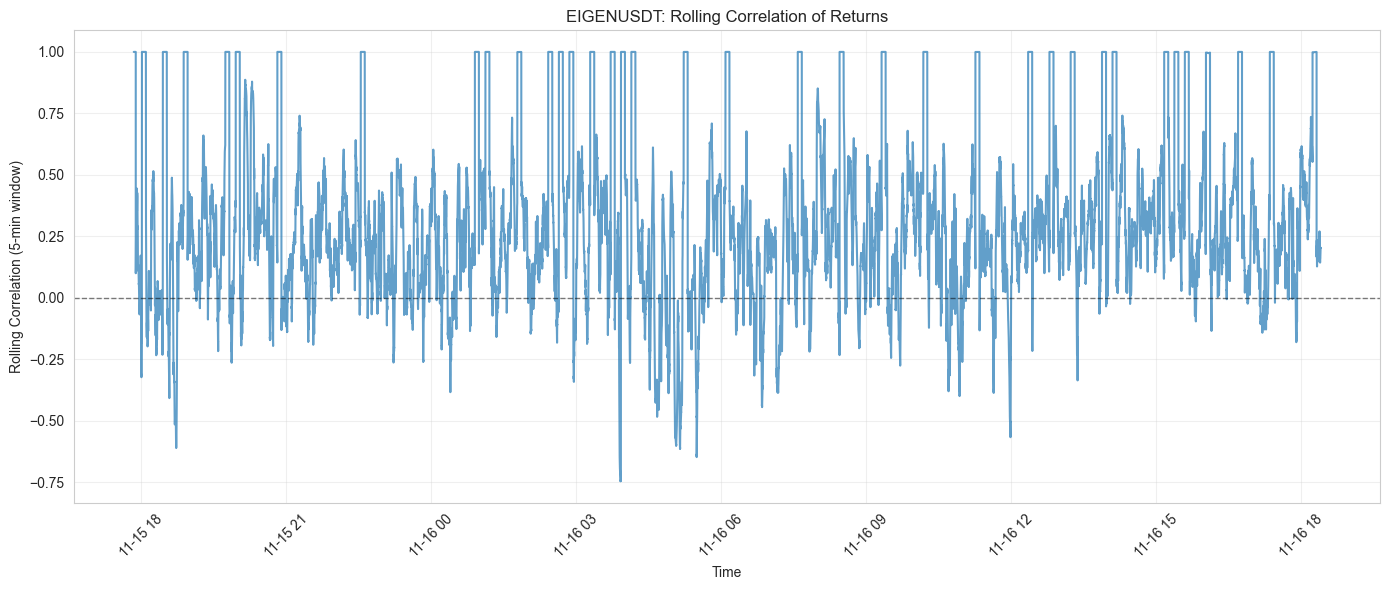

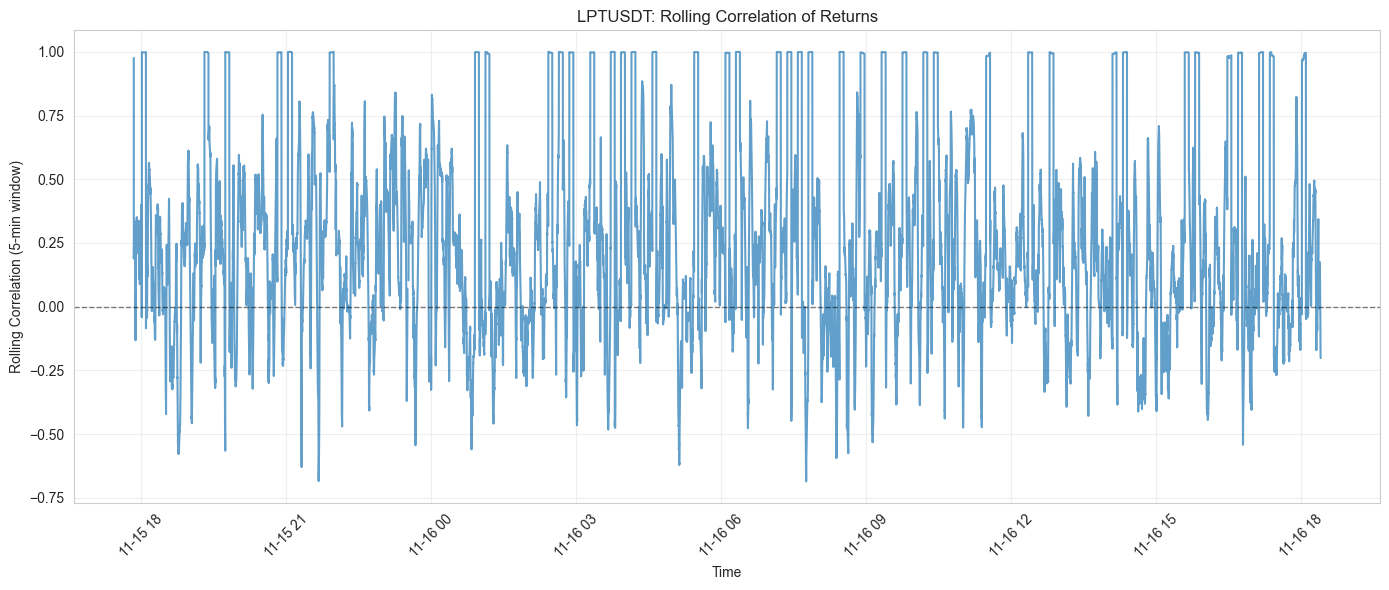

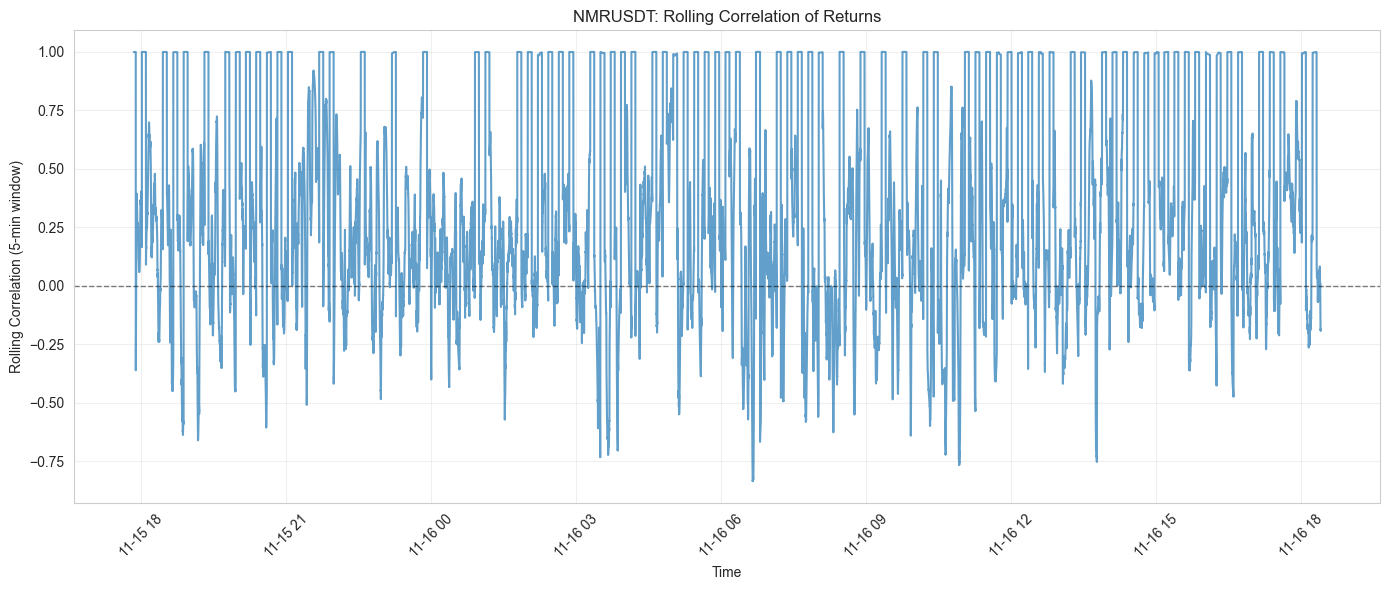

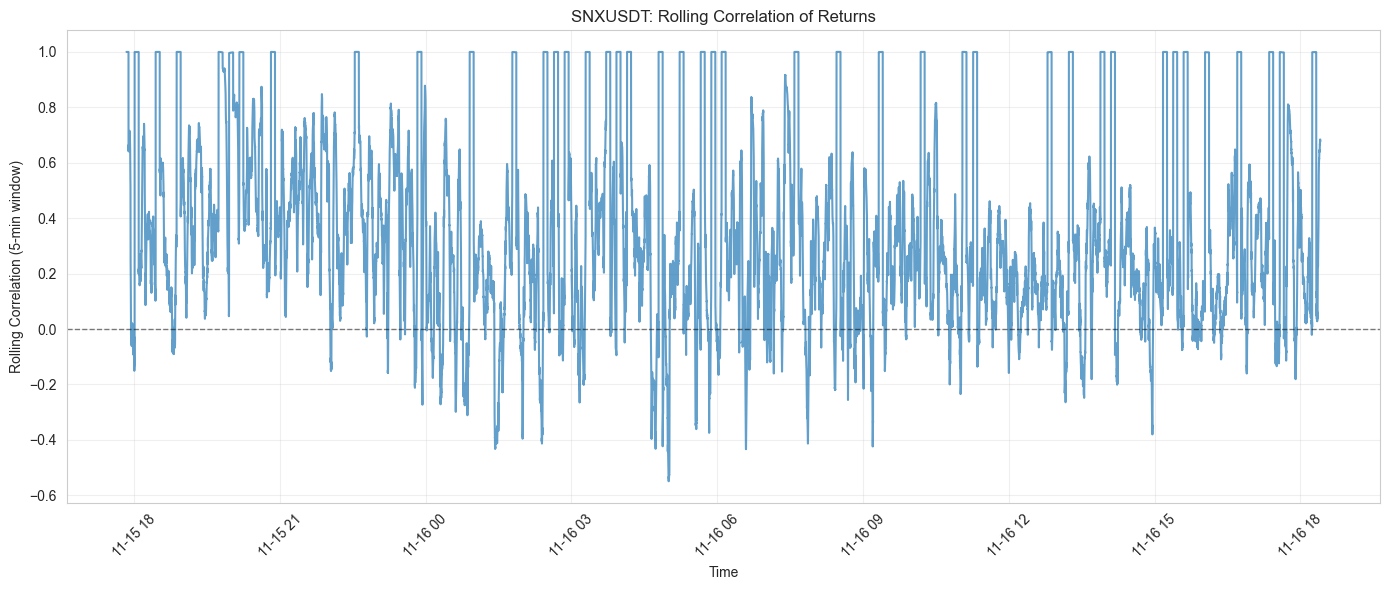

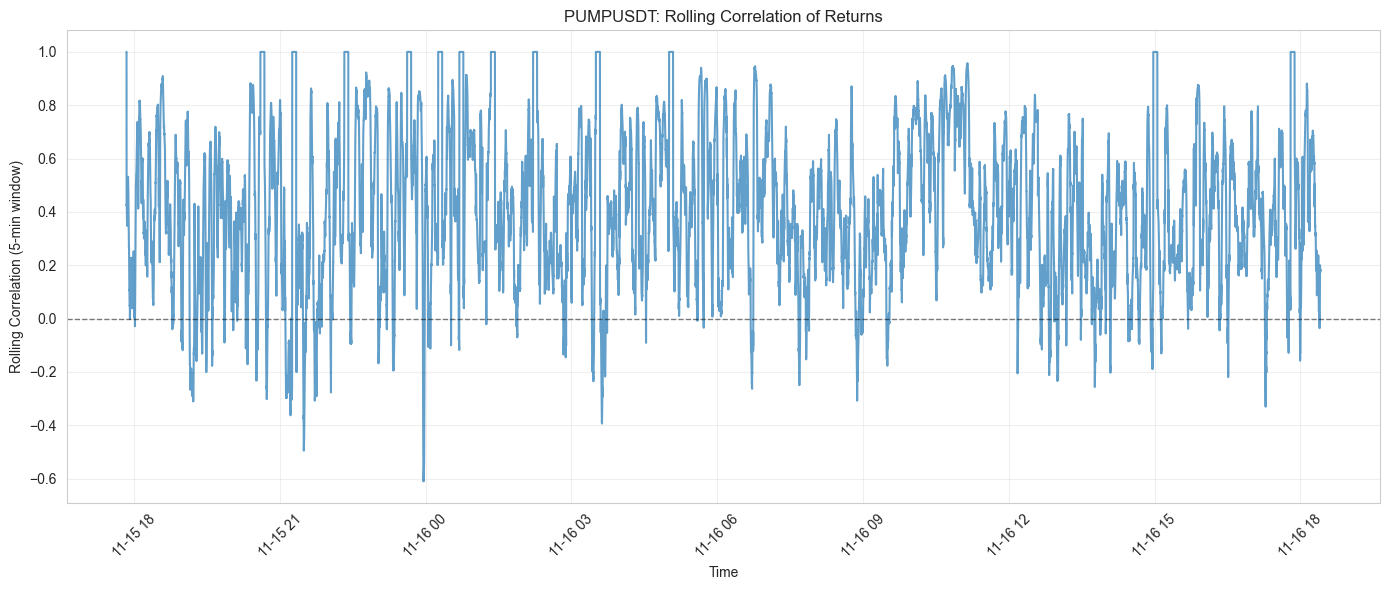

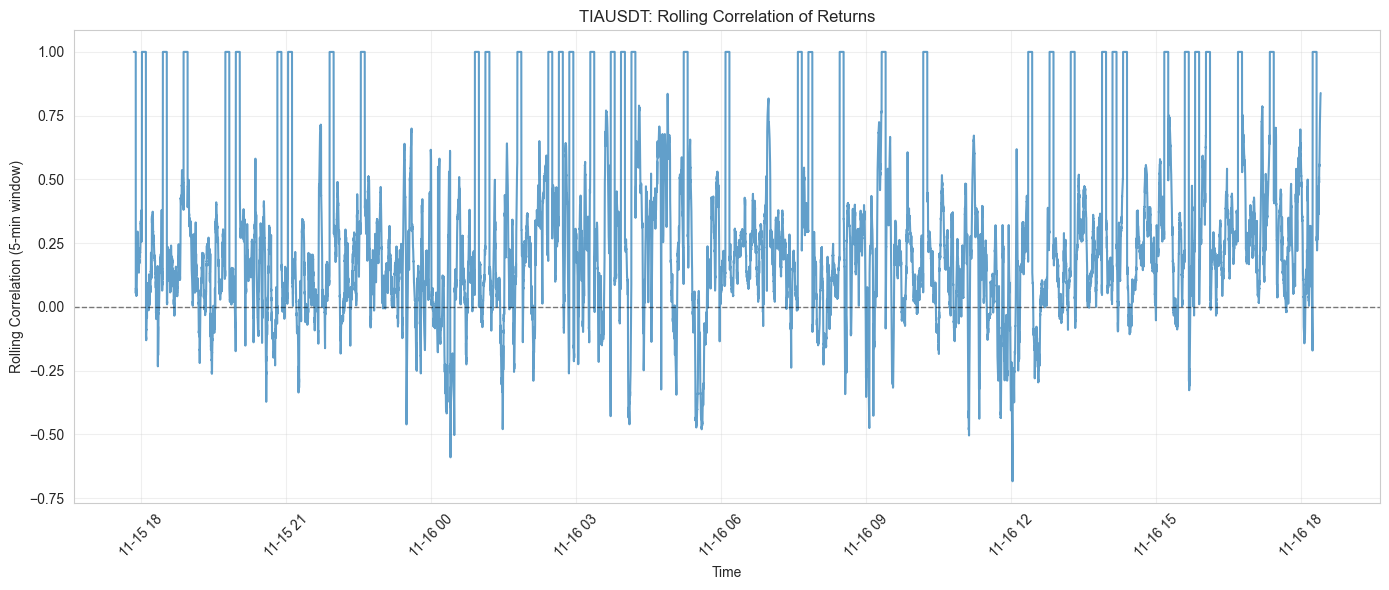

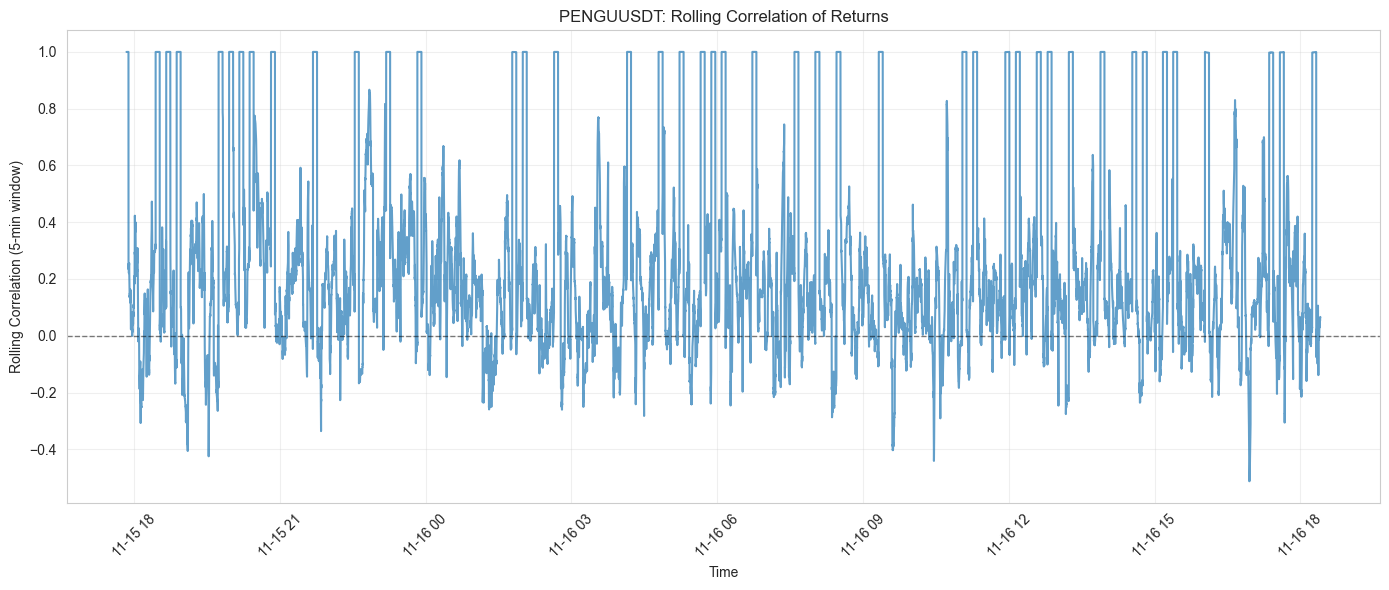

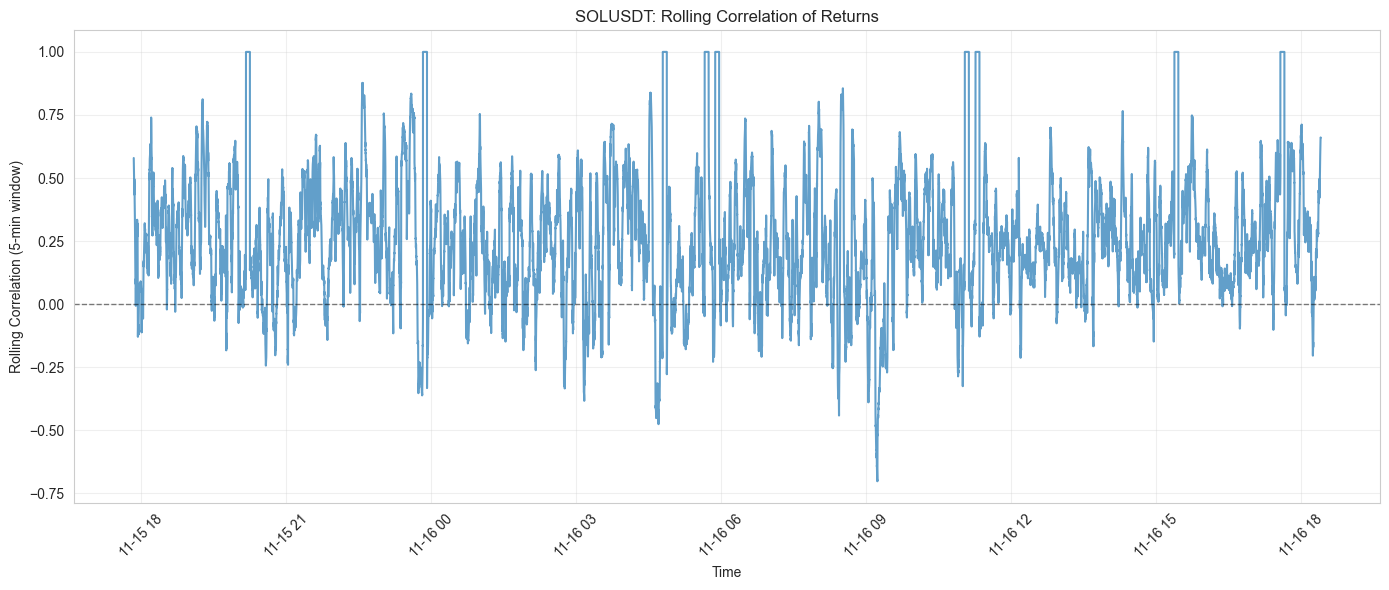

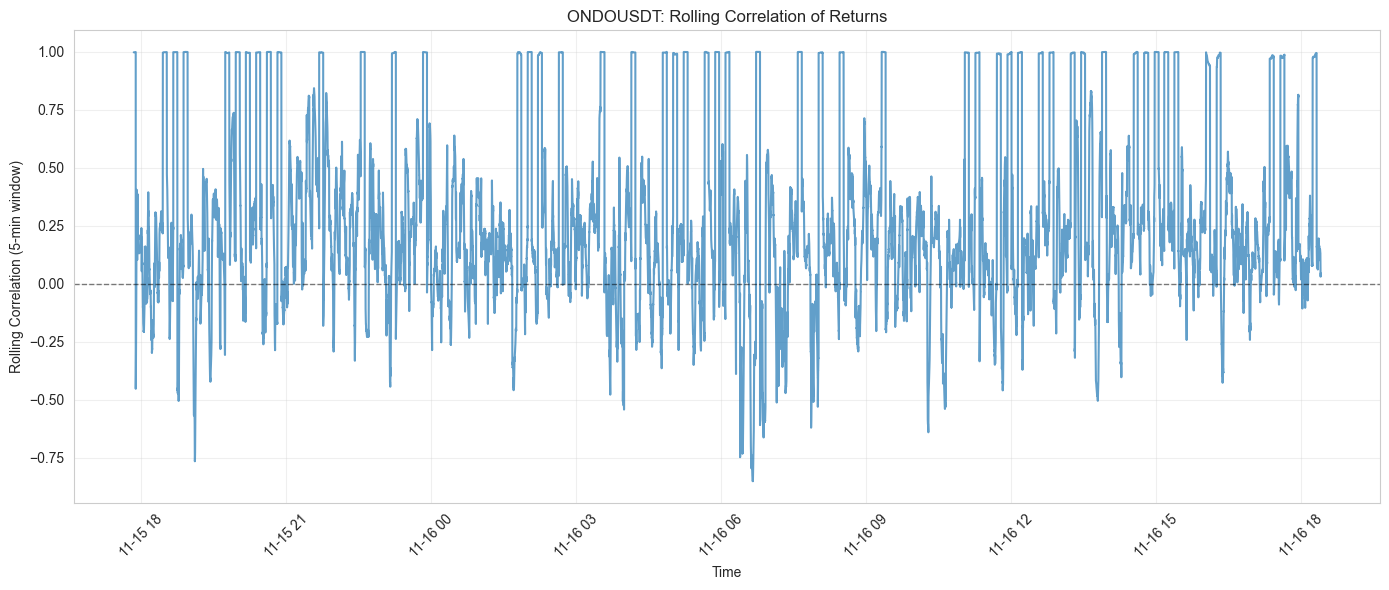

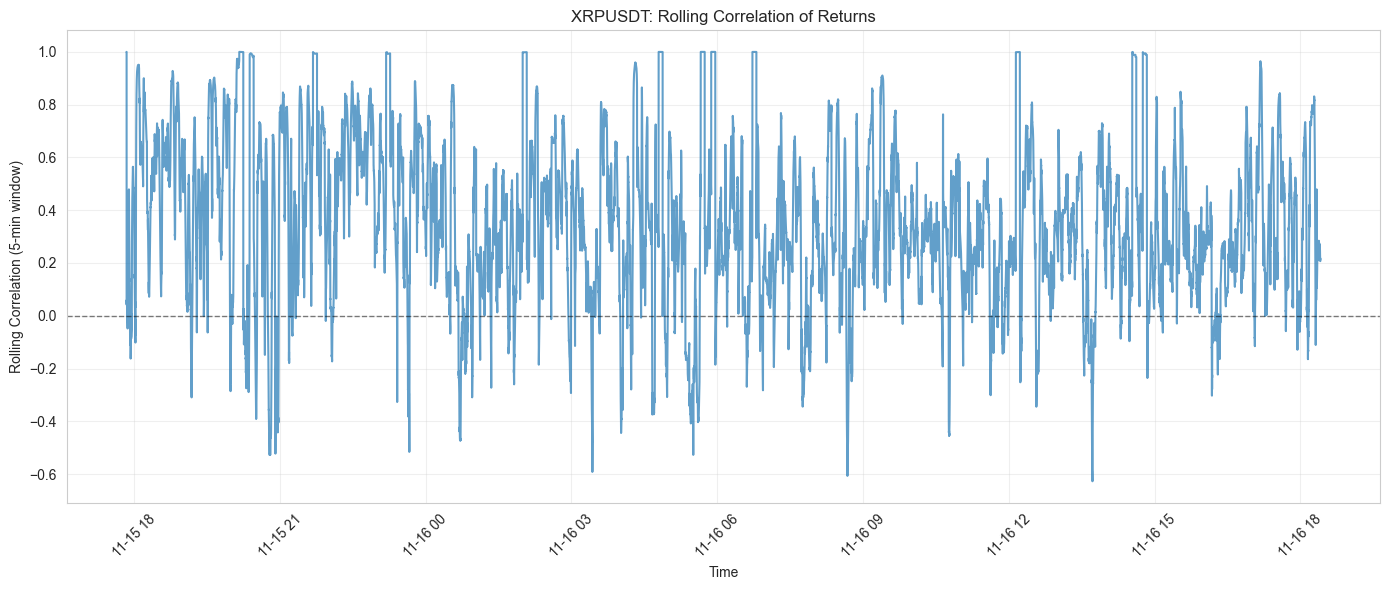

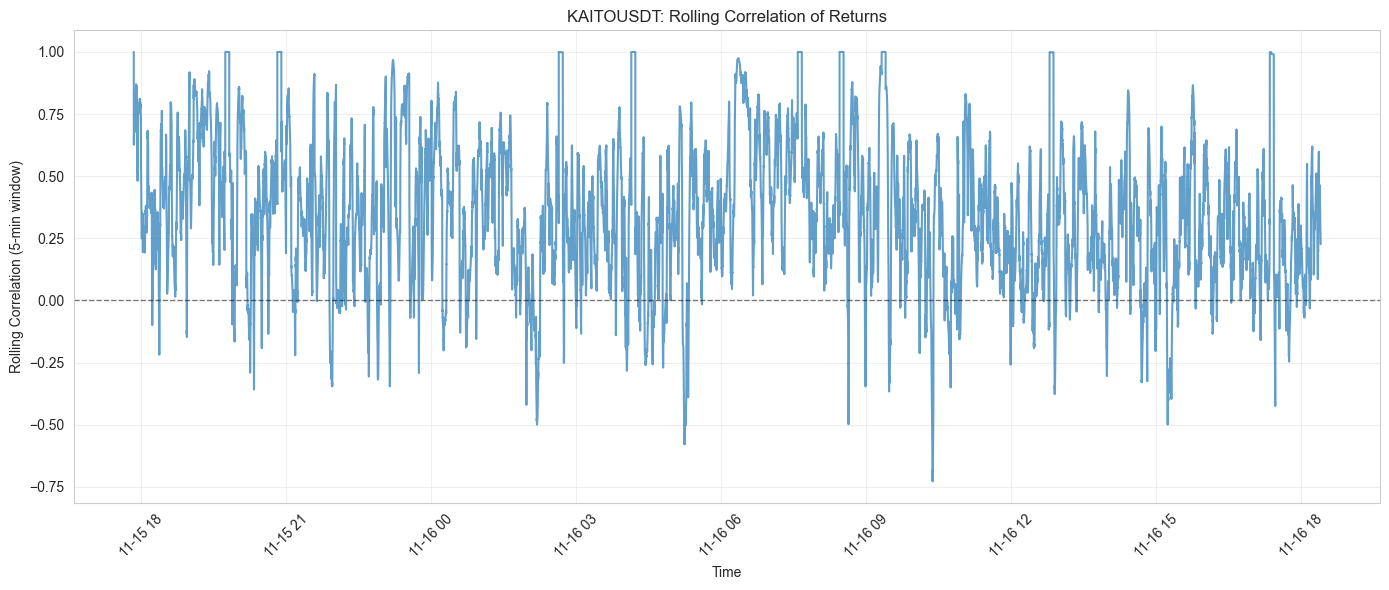

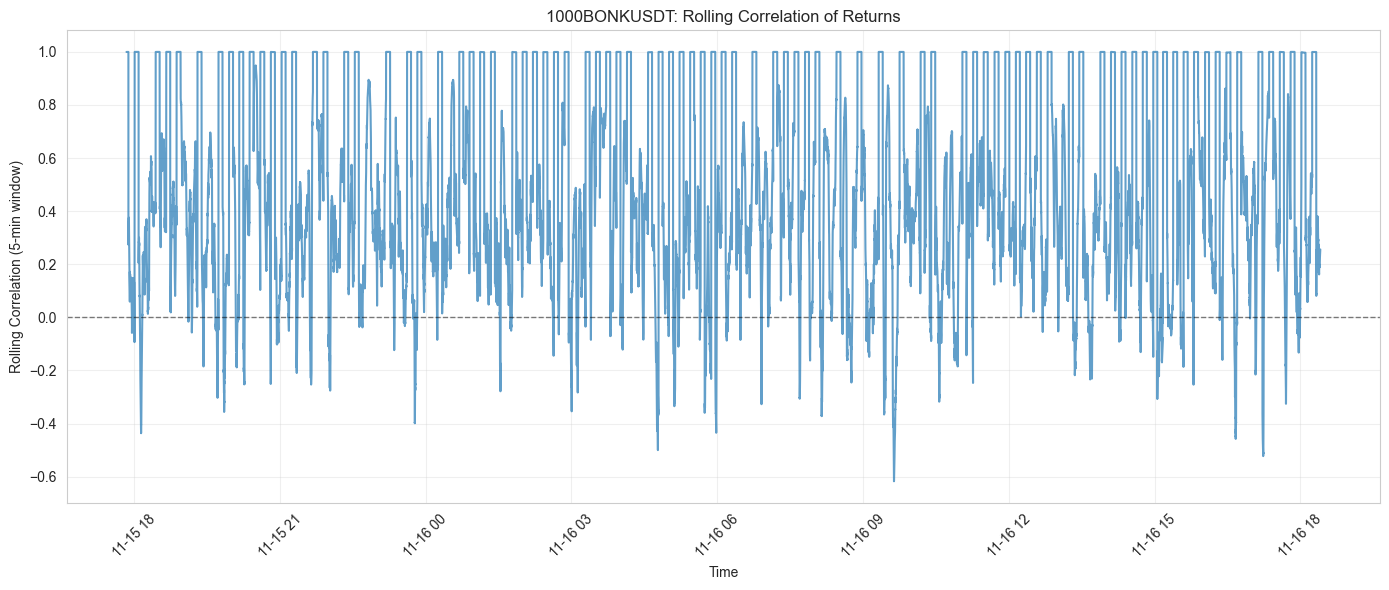

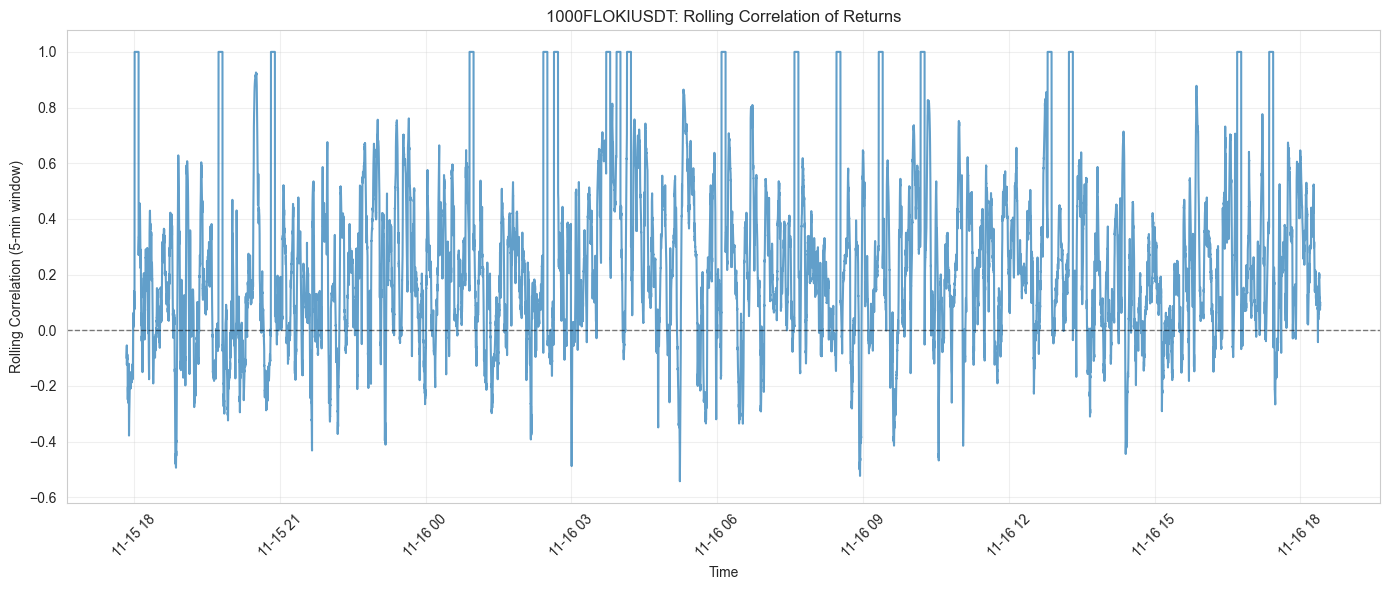

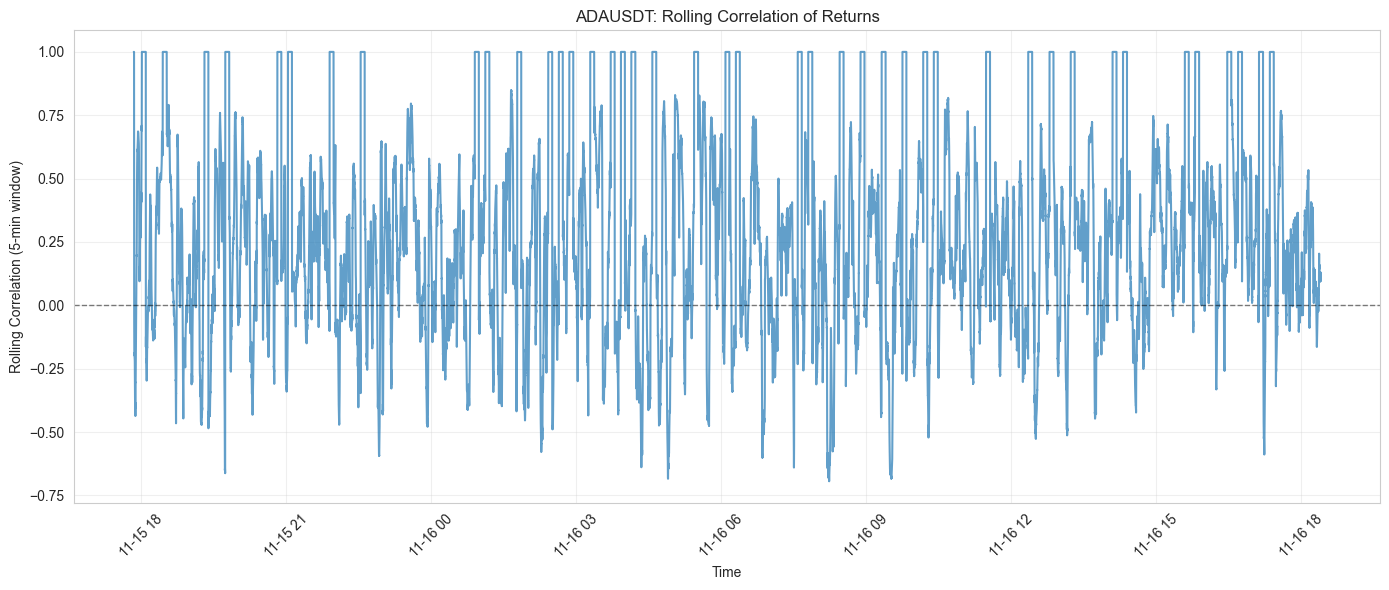

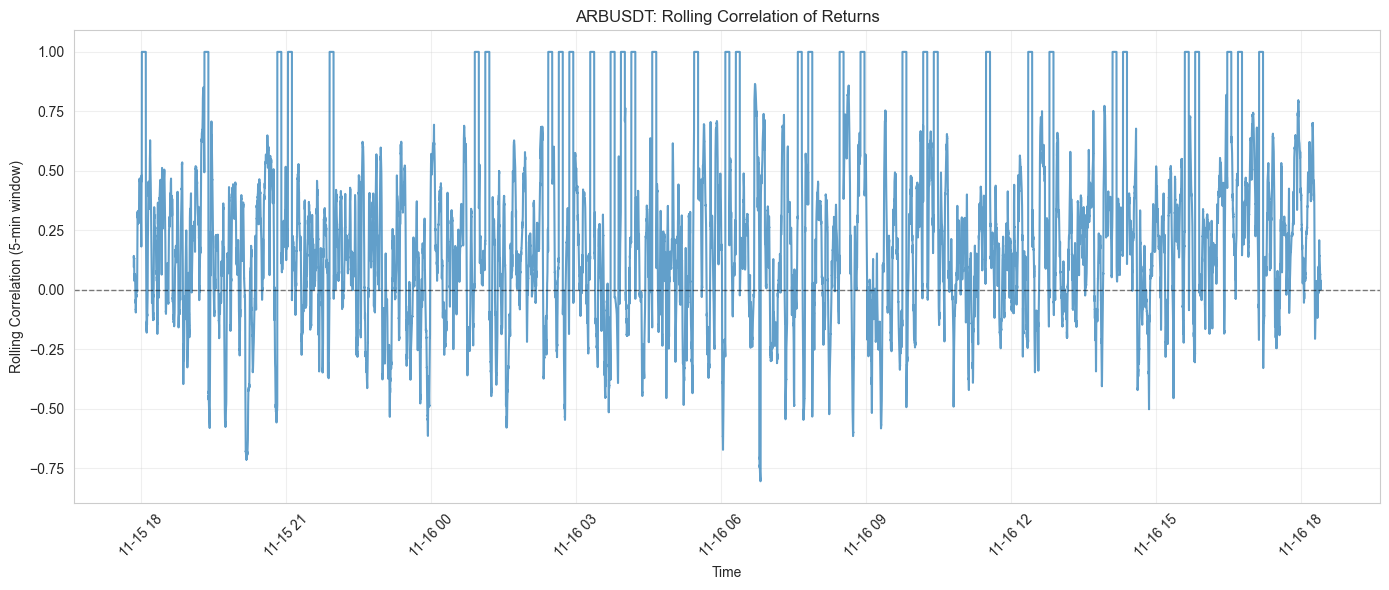

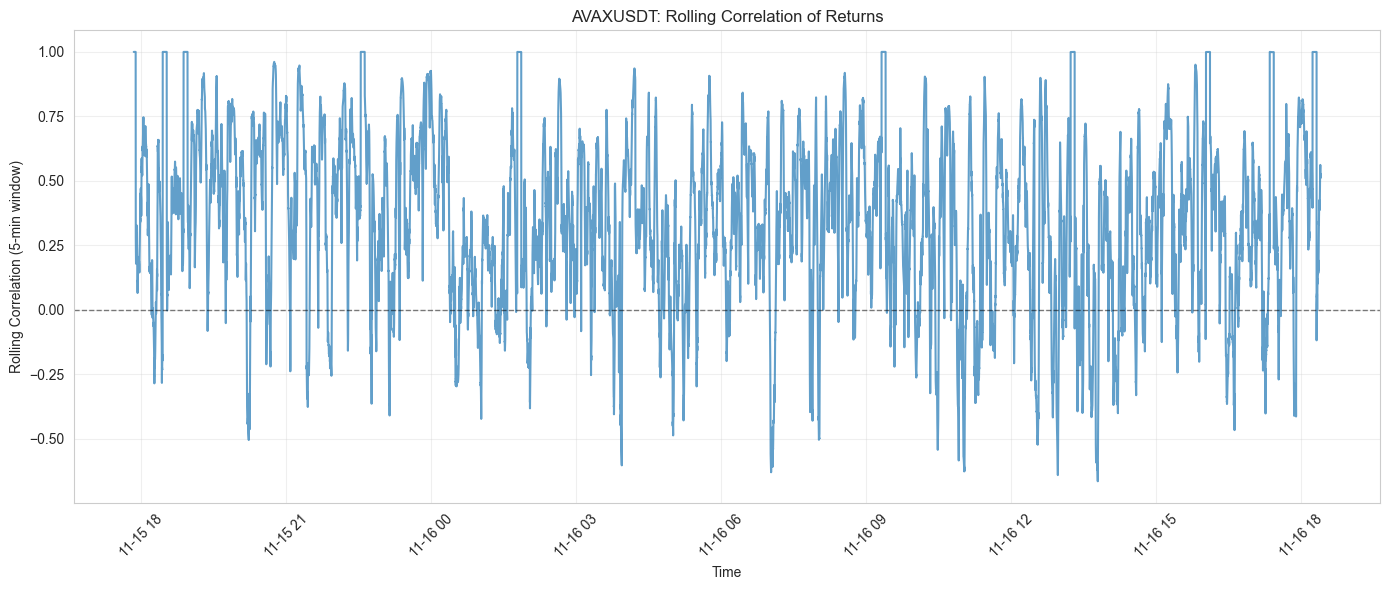

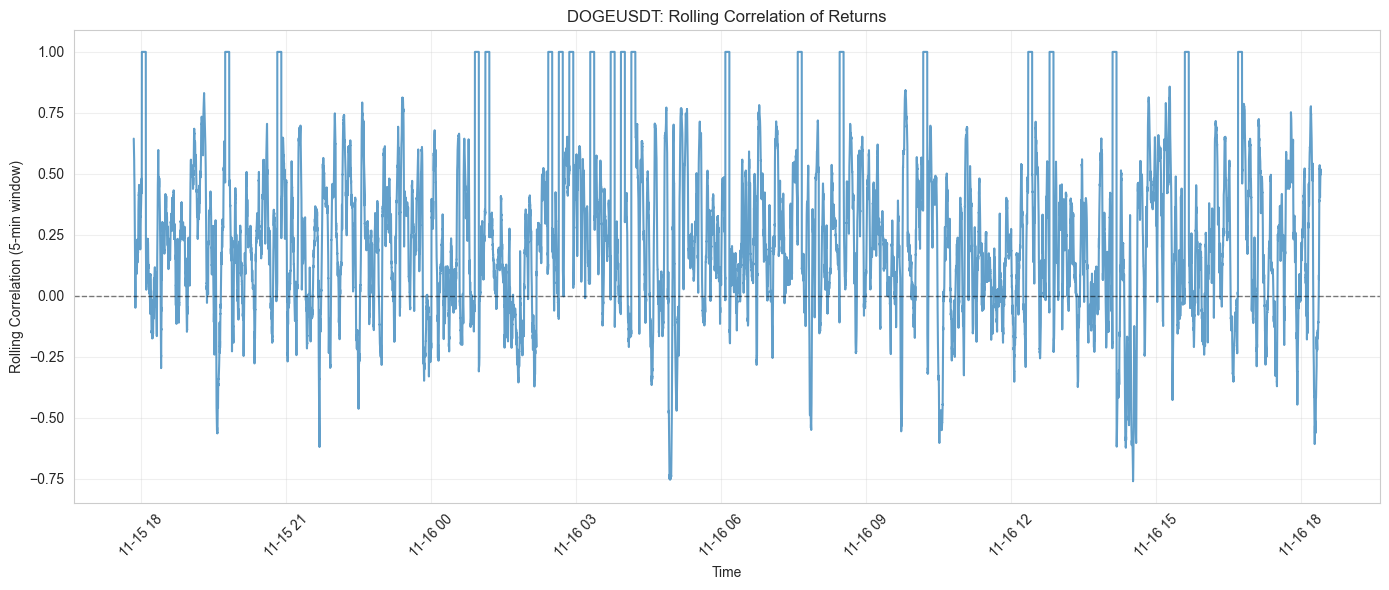

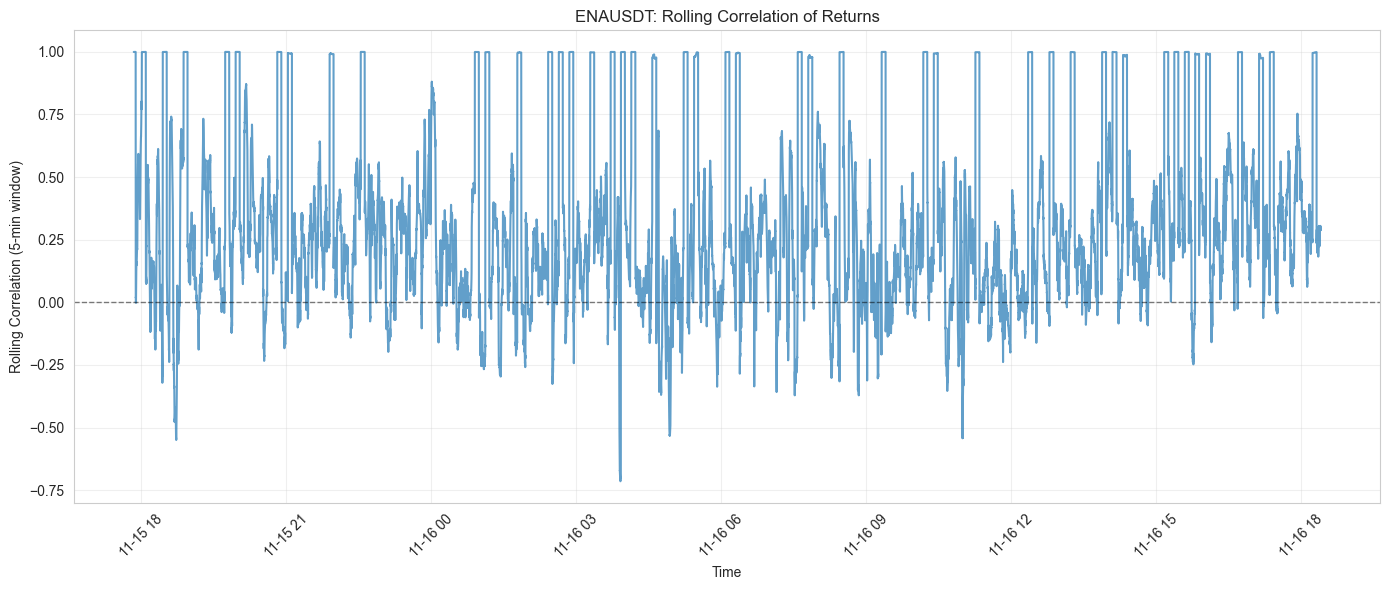

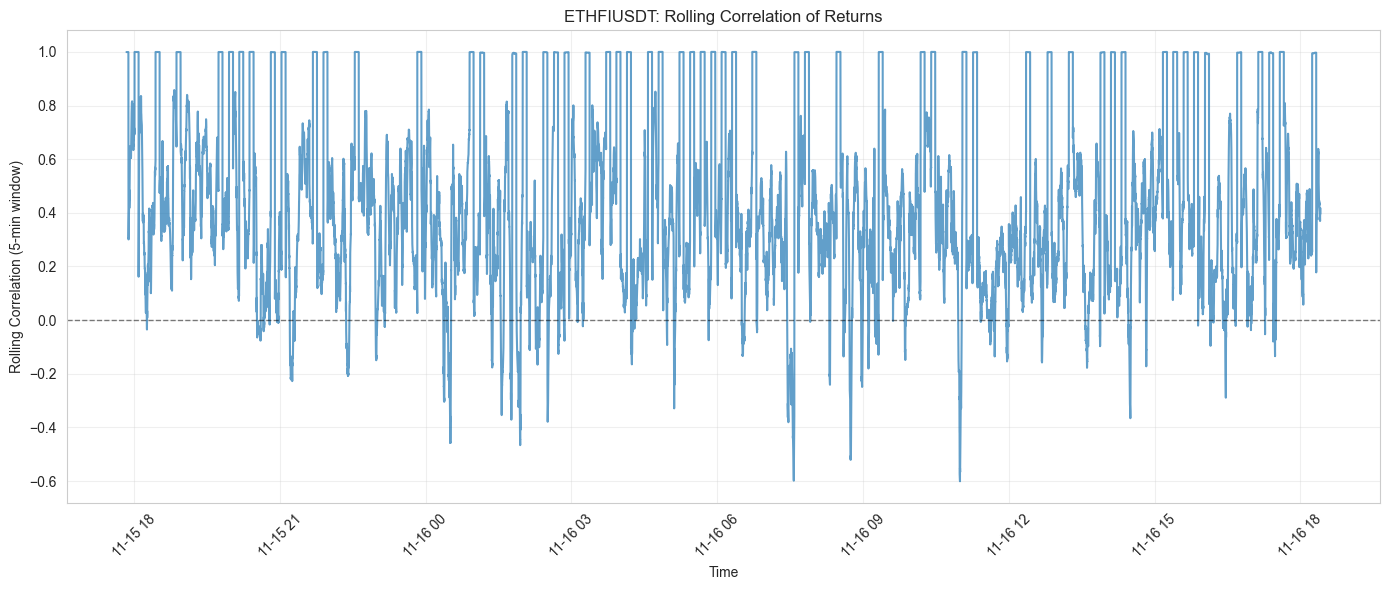

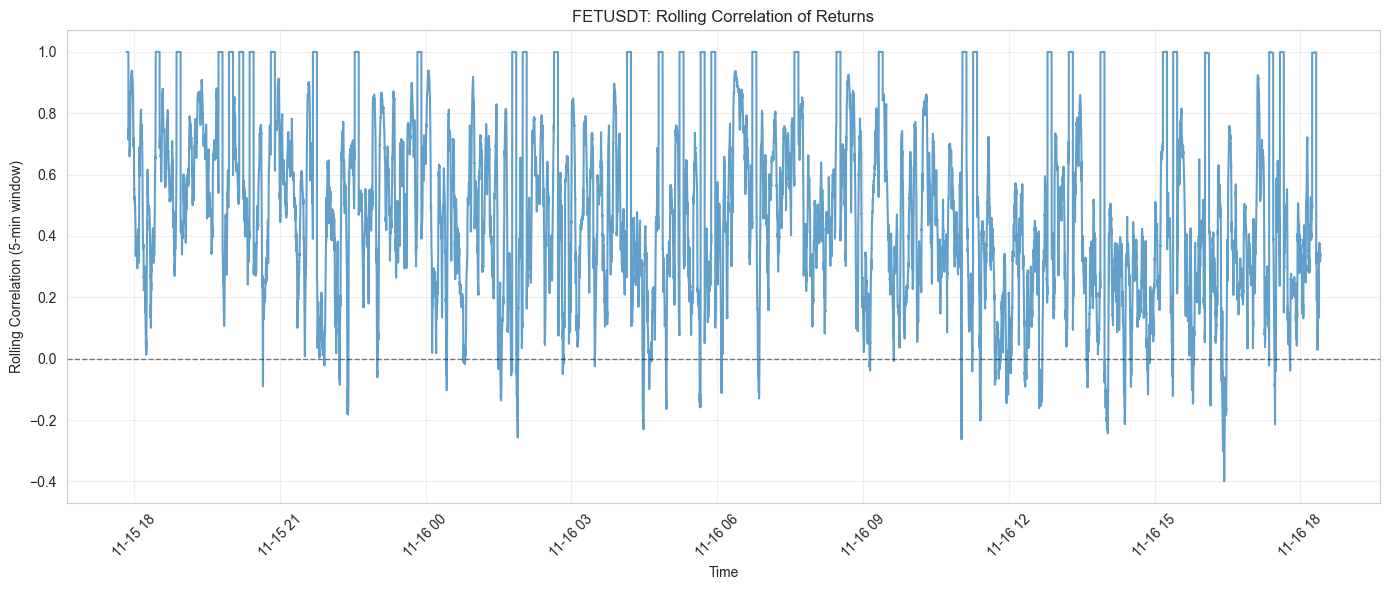

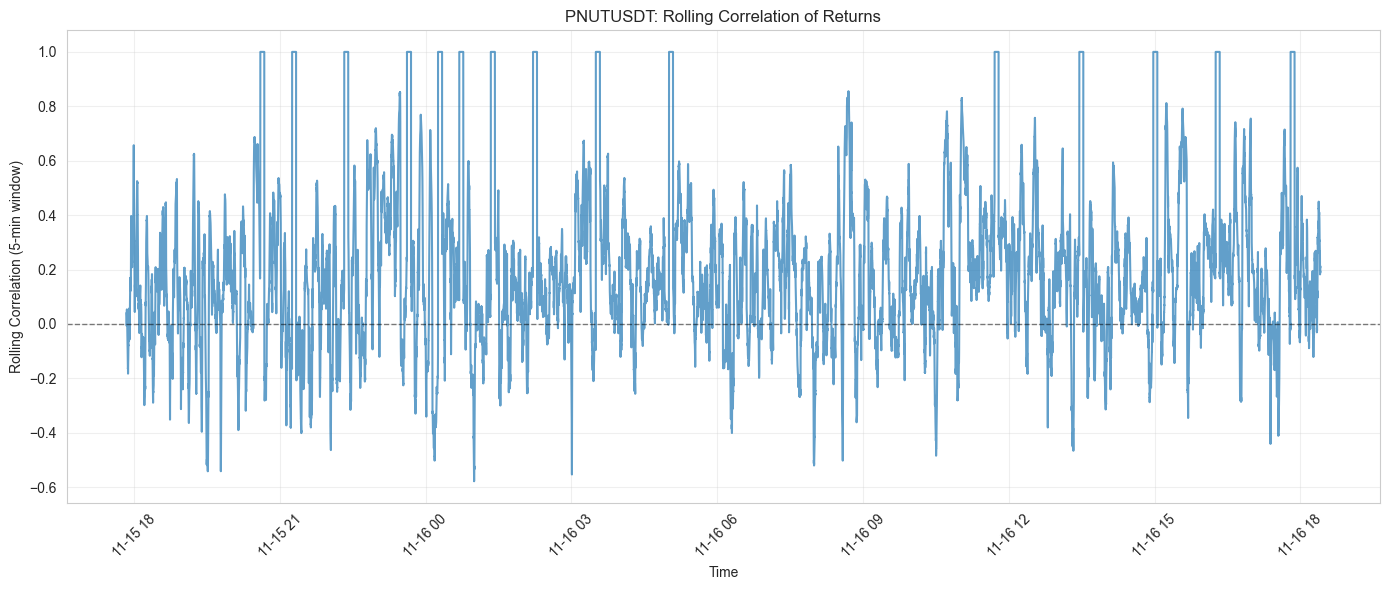

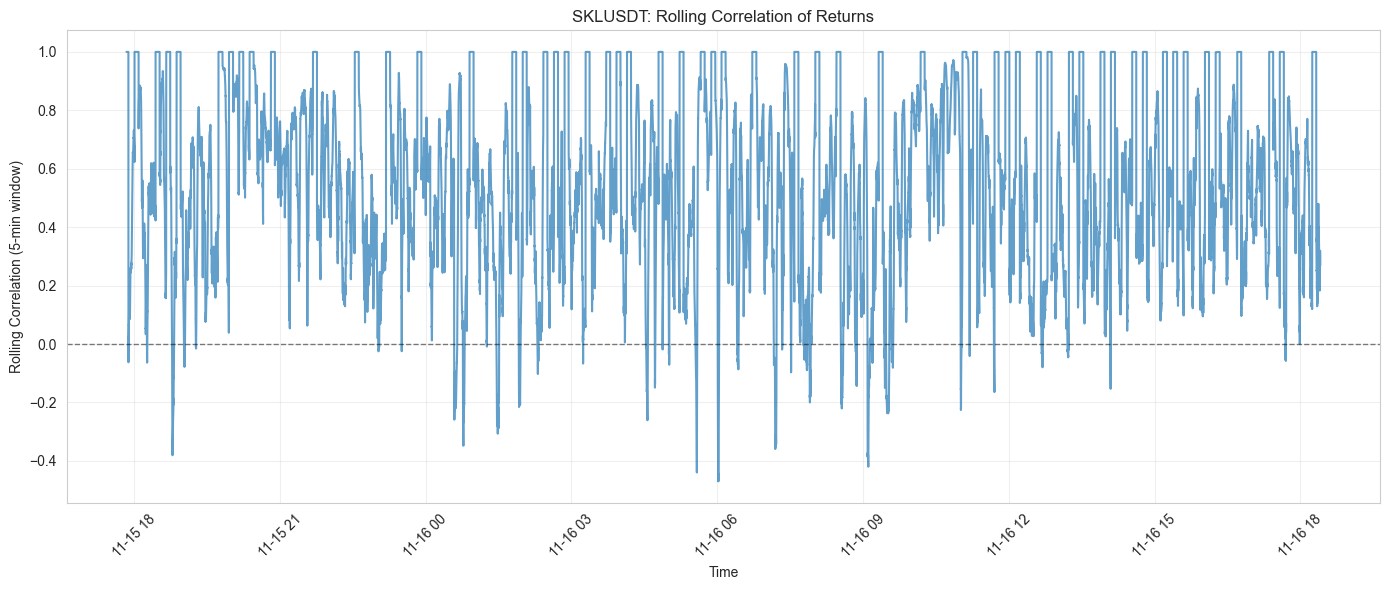

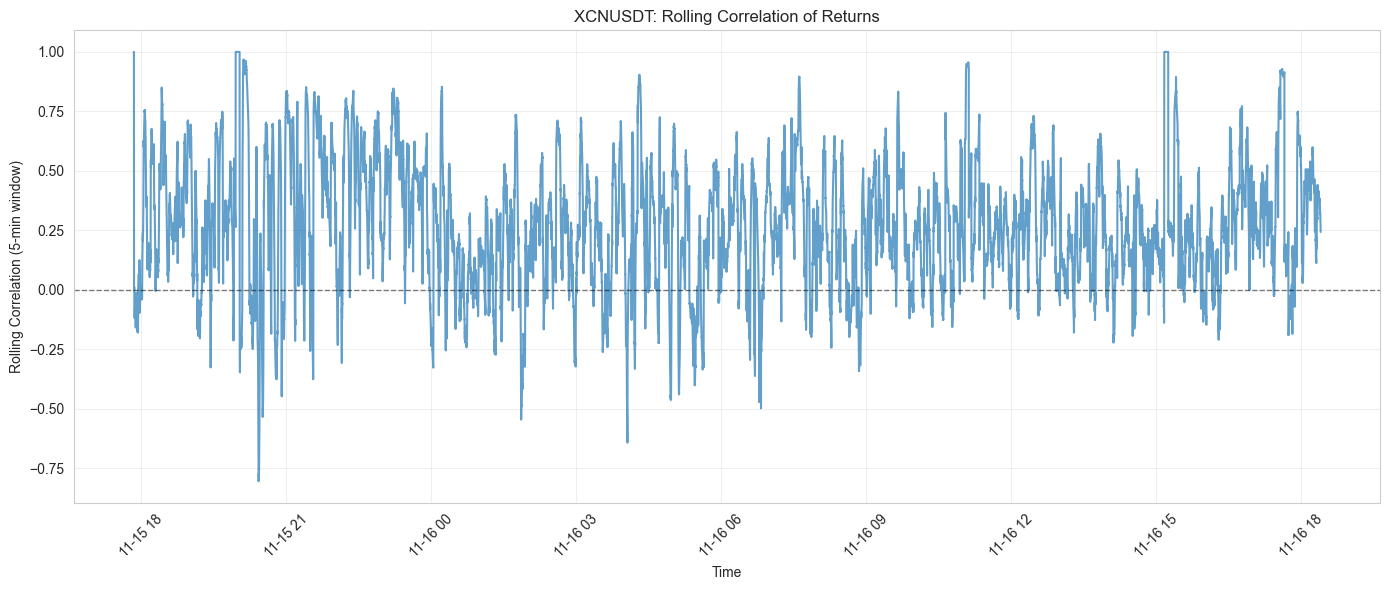

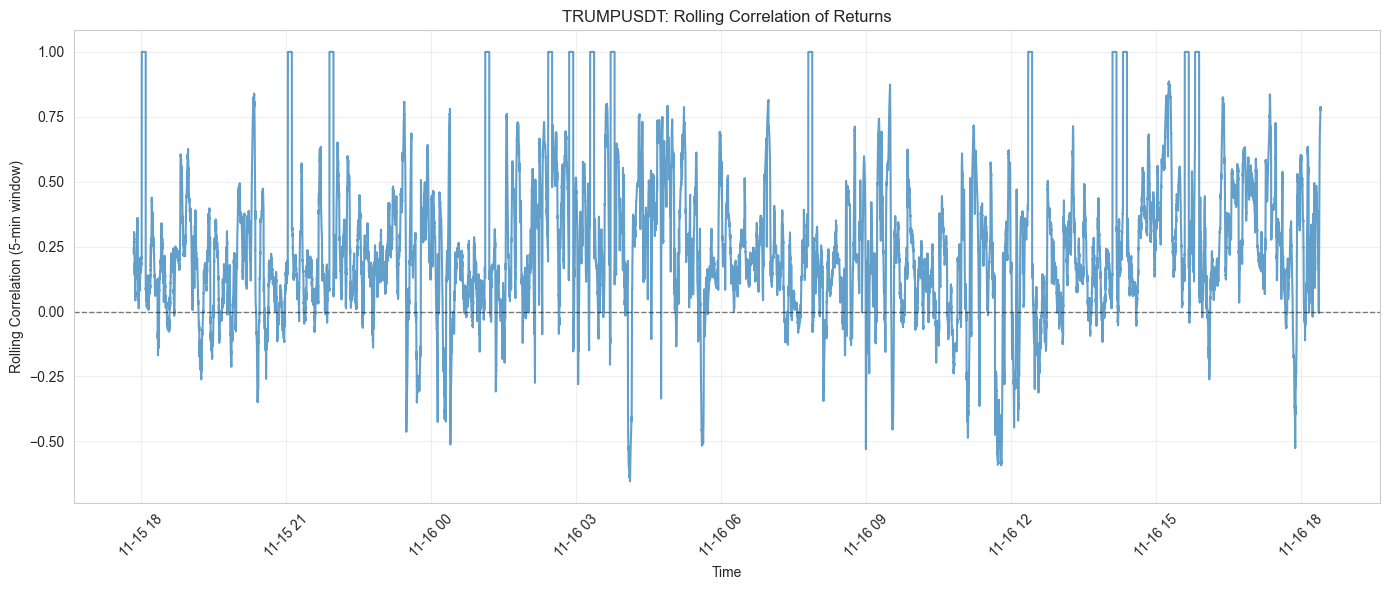

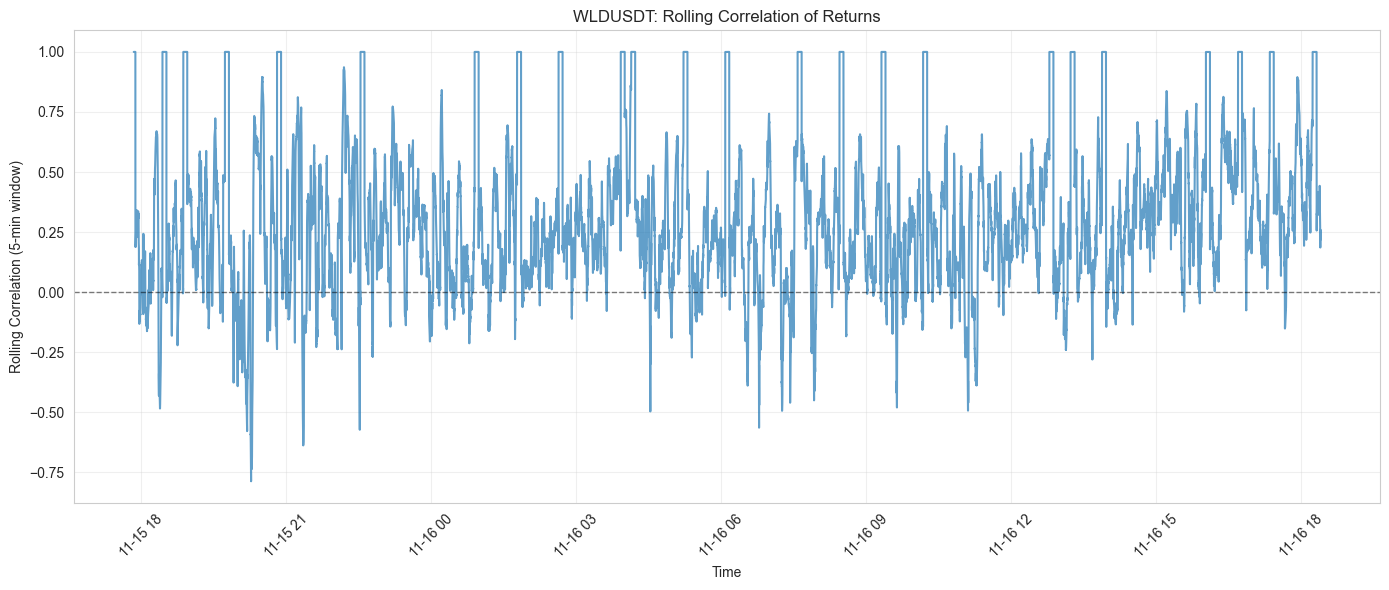

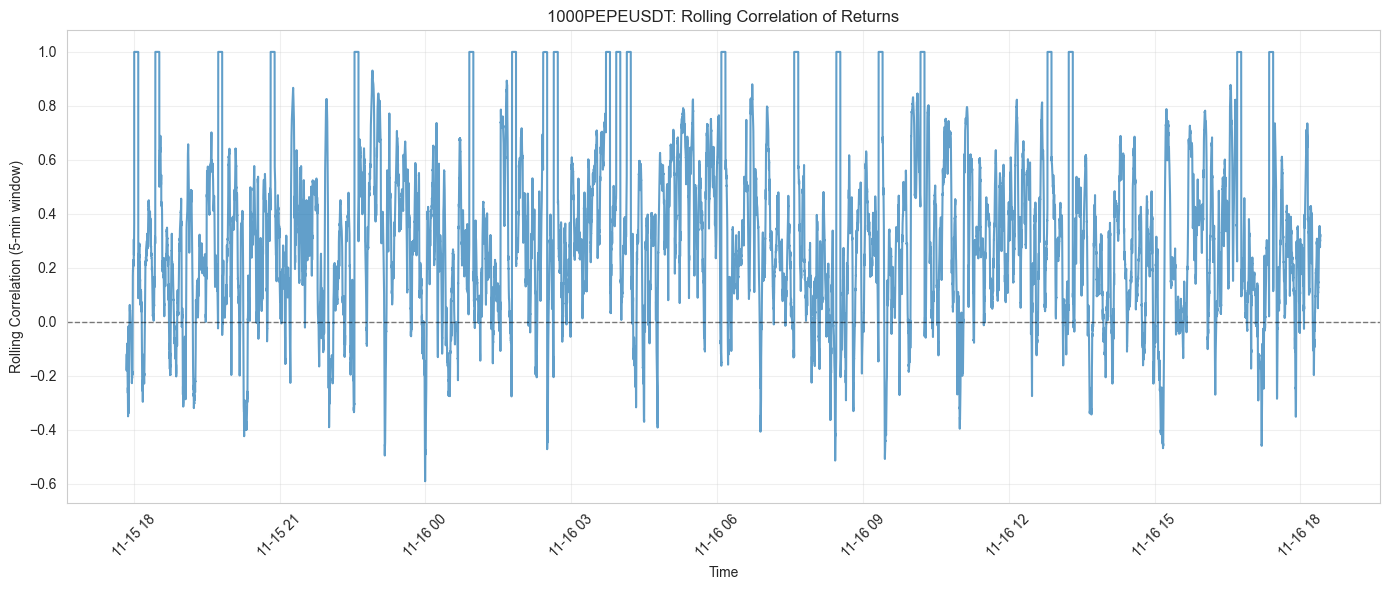

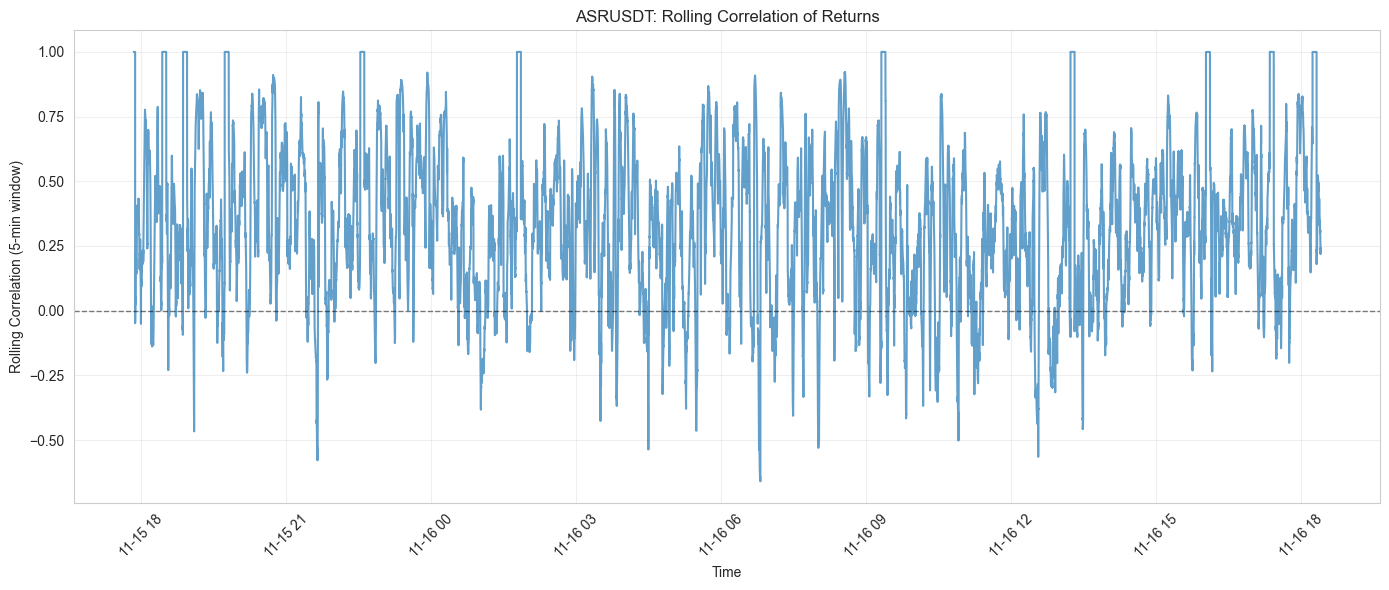

In [8]:
# Calculate log returns
df_aligned['ret_ex1'] = calculate_log_returns(df_aligned['mid_ex1'])
df_aligned['ret_ex2'] = calculate_log_returns(df_aligned['mid_ex2'])

# Calculate rolling correlation (5-minute window = 300 seconds) per symbol
df_aligned['rolling_corr'] = np.nan
for symbol in df_aligned['symbol'].unique():
    symbol_mask = df_aligned['symbol'] == symbol
    symbol_data = df_aligned[symbol_mask].copy()
    rolling_corr = calculate_rolling_correlation(symbol_data['ret_ex1'], symbol_data['ret_ex2'], window=300)
    df_aligned.loc[symbol_mask, 'rolling_corr'] = rolling_corr.values

# Plot rolling correlation for each coin
for symbol in df_aligned['symbol'].unique():
    symbol_data = df_aligned[df_aligned['symbol'] == symbol]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(symbol_data['timestamp'], symbol_data['rolling_corr'], alpha=0.7)
    ax.set_xlabel('Time')
    ax.set_ylabel('Rolling Correlation (5-min window)')
    ax.set_title(f'{symbol}: Rolling Correlation of Returns')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../results/figures/rolling_corr_{symbol}.png', dpi=150, bbox_inches='tight')
    plt.show()




EIGENUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.011771
1    -9     0.011706
2    -8     0.011868
3    -7     0.011866
4    -6     0.018843
5    -5     0.026609
6    -4     0.034200
7    -3     0.046130
8    -2     0.055590
9    -1     0.064523
10    0     0.998883
11    1     0.064523
12    2     0.055590
13    3     0.046130
14    4     0.034200
15    5     0.026609
16    6     0.018843
17    7     0.011866
18    8     0.011868
19    9     0.011706
20   10     0.011771

Best correlation: 0.9989 at lag 0
  → No significant lead-lag relationship


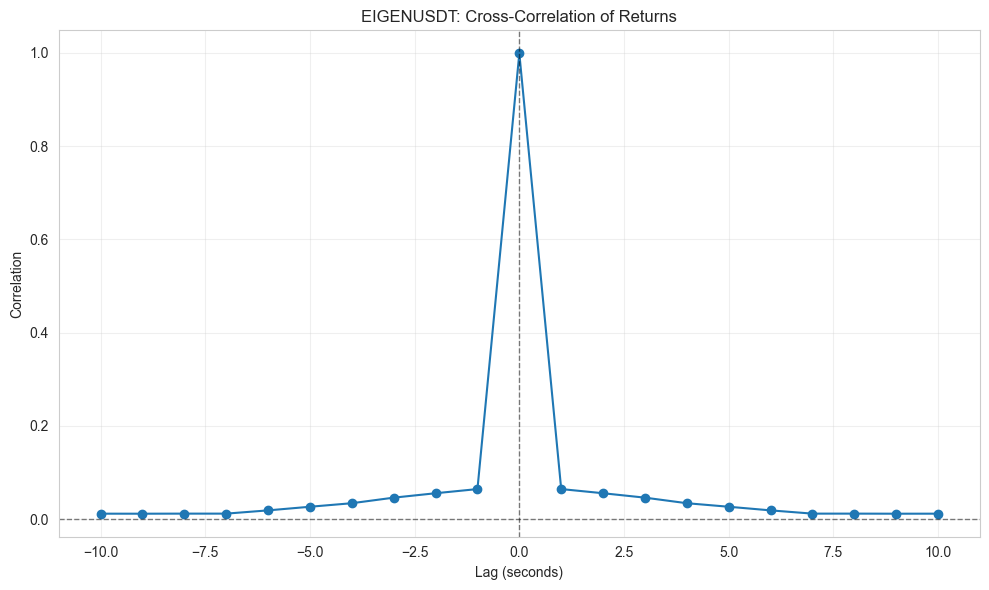


LPTUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.173856
1    -9     0.173914
2    -8     0.173539
3    -7     0.173987
4    -6     0.173709
5    -5     0.173938
6    -4     0.173839
7    -3     0.174140
8    -2     0.173925
9    -1     0.174090
10    0     0.982378
11    1     0.174090
12    2     0.173925
13    3     0.174140
14    4     0.173839
15    5     0.173938
16    6     0.173709
17    7     0.173987
18    8     0.173539
19    9     0.173914
20   10     0.173856

Best correlation: 0.9824 at lag 0
  → No significant lead-lag relationship


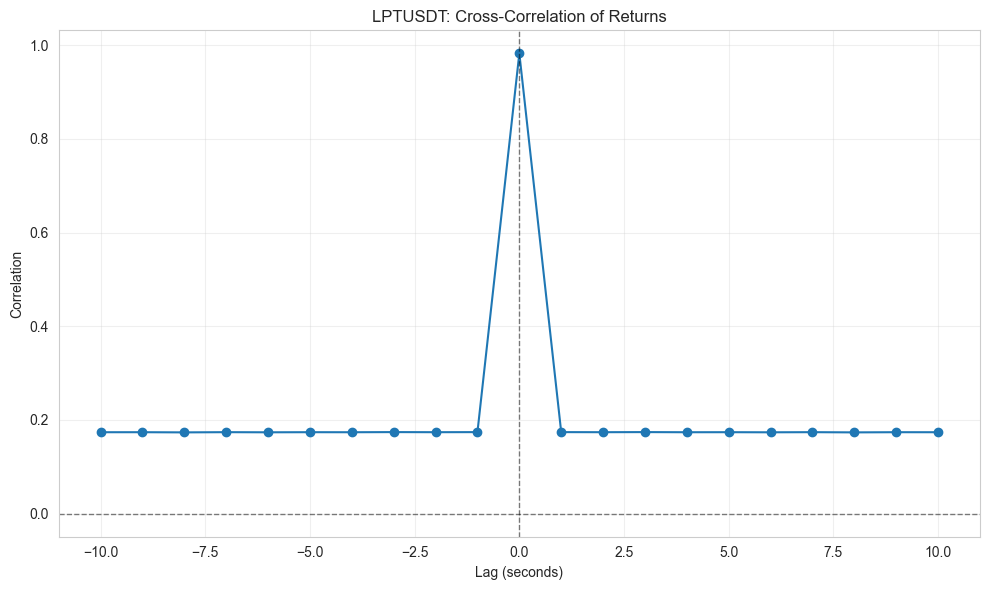


NMRUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.013067
1    -9     0.012888
2    -8     0.013227
3    -7     0.013016
4    -6     0.013083
5    -5     0.013058
6    -4     0.013079
7    -3     0.012857
8    -2     0.013175
9    -1     0.013350
10    0     0.996103
11    1     0.013350
12    2     0.013175
13    3     0.012857
14    4     0.013079
15    5     0.013058
16    6     0.013083
17    7     0.013016
18    8     0.013227
19    9     0.012888
20   10     0.013067

Best correlation: 0.9961 at lag 0
  → No significant lead-lag relationship


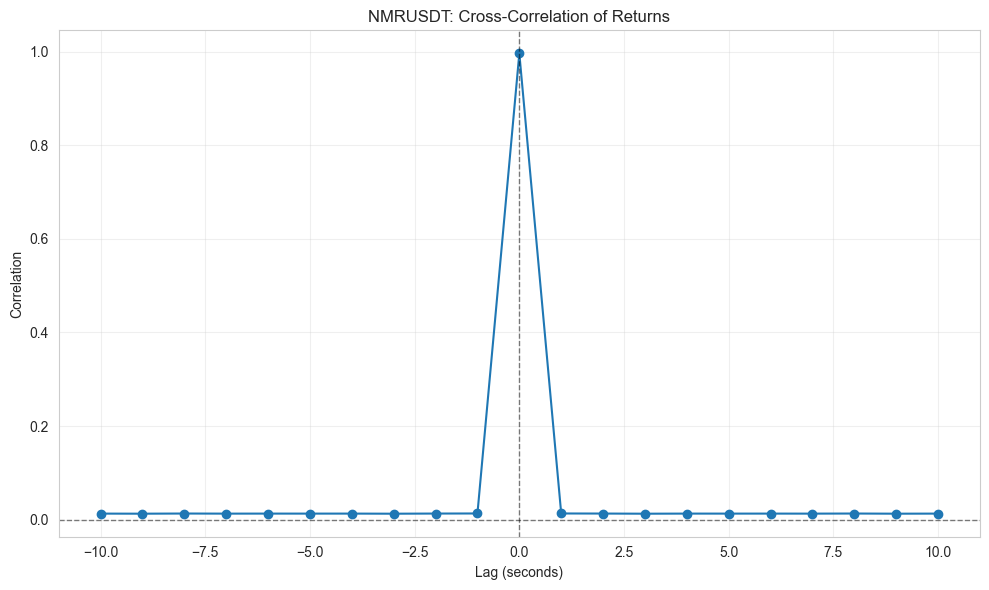


SNXUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.056615
1    -9     0.056548
2    -8     0.056822
3    -7    -0.019880
4    -6    -0.002672
5    -5     0.014325
6    -4     0.031270
7    -3     0.047512
8    -2     0.063563
9    -1     0.079135
10    0     0.997501
11    1     0.079135
12    2     0.063563
13    3     0.047512
14    4     0.031270
15    5     0.014325
16    6    -0.002672
17    7    -0.019880
18    8     0.056822
19    9     0.056548
20   10     0.056615

Best correlation: 0.9975 at lag 0
  → No significant lead-lag relationship


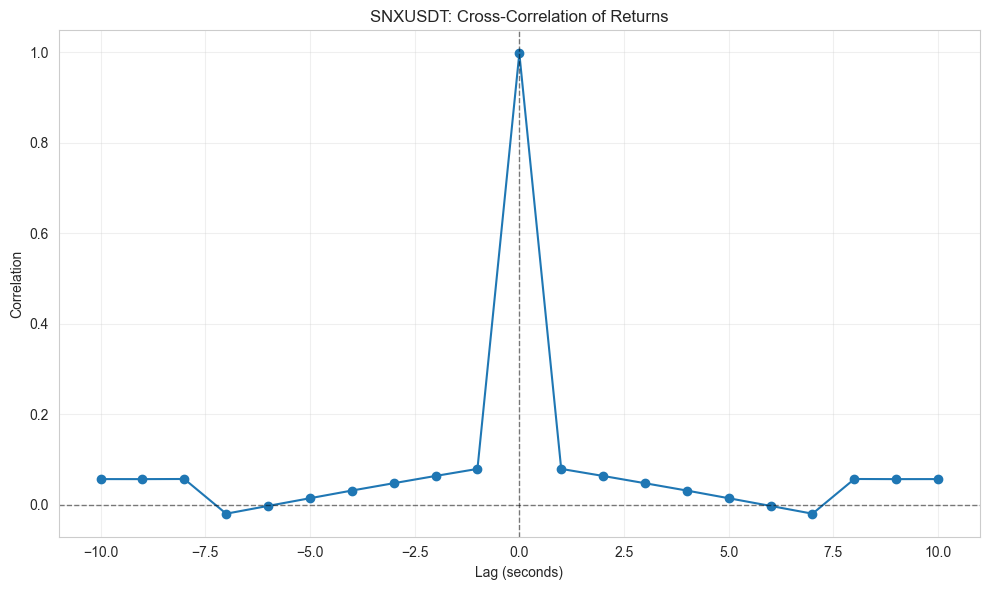


PUMPUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.133899
1    -9     0.133971
2    -8     0.133989
3    -7     0.133943
4    -6     0.016171
5    -5     0.063969
6    -4     0.109047
7    -3     0.151636
8    -2     0.192134
9    -1     0.230506
10    0     0.997685
11    1     0.230506
12    2     0.192134
13    3     0.151636
14    4     0.109047
15    5     0.063969
16    6     0.016171
17    7     0.133943
18    8     0.133989
19    9     0.133971
20   10     0.133899

Best correlation: 0.9977 at lag 0
  → No significant lead-lag relationship


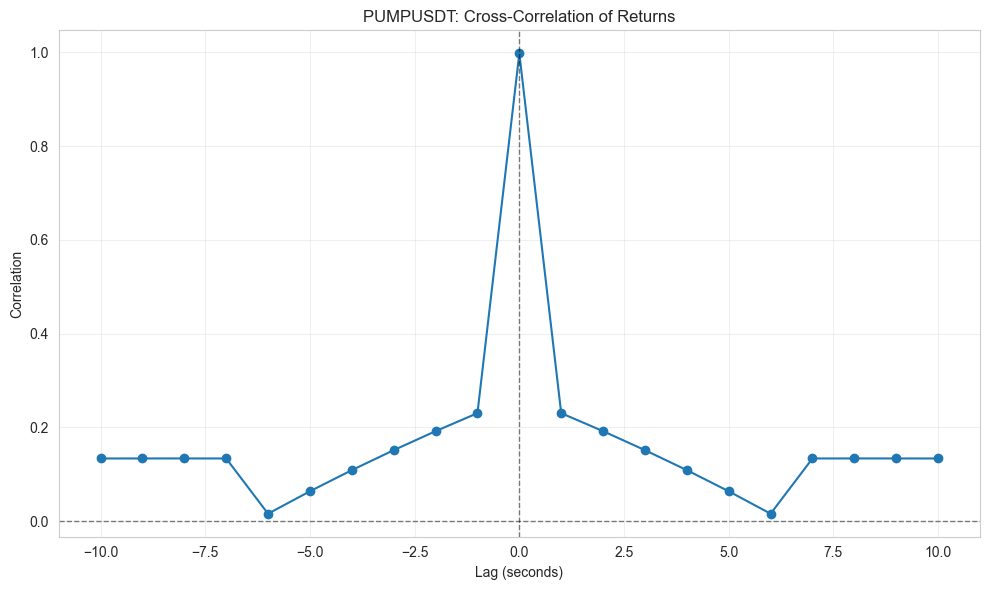


TIAUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.002099
1    -9     0.002050
2    -8     0.002061
3    -7     0.002145
4    -6     0.002053
5    -5     0.002052
6    -4     0.002098
7    -3     0.002053
8    -2     0.002062
9    -1     0.002080
10    0     0.999728
11    1     0.002080
12    2     0.002062
13    3     0.002053
14    4     0.002098
15    5     0.002052
16    6     0.002053
17    7     0.002145
18    8     0.002061
19    9     0.002050
20   10     0.002099

Best correlation: 0.9997 at lag 0
  → No significant lead-lag relationship


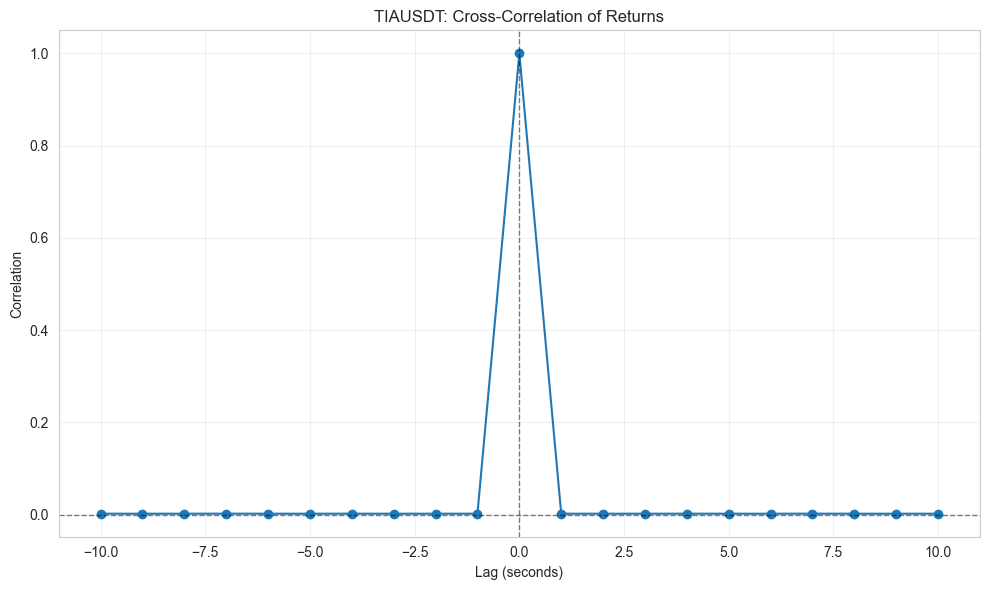


PENGUUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.005923
1    -9     0.005805
2    -8     0.005856
3    -7     0.005767
4    -6     0.005687
5    -5     0.005729
6    -4     0.005624
7    -3     0.005674
8    -2     0.005409
9    -1     0.006219
10    0     0.997971
11    1     0.006219
12    2     0.005409
13    3     0.005674
14    4     0.005624
15    5     0.005729
16    6     0.005687
17    7     0.005767
18    8     0.005856
19    9     0.005805
20   10     0.005923

Best correlation: 0.9980 at lag 0
  → No significant lead-lag relationship


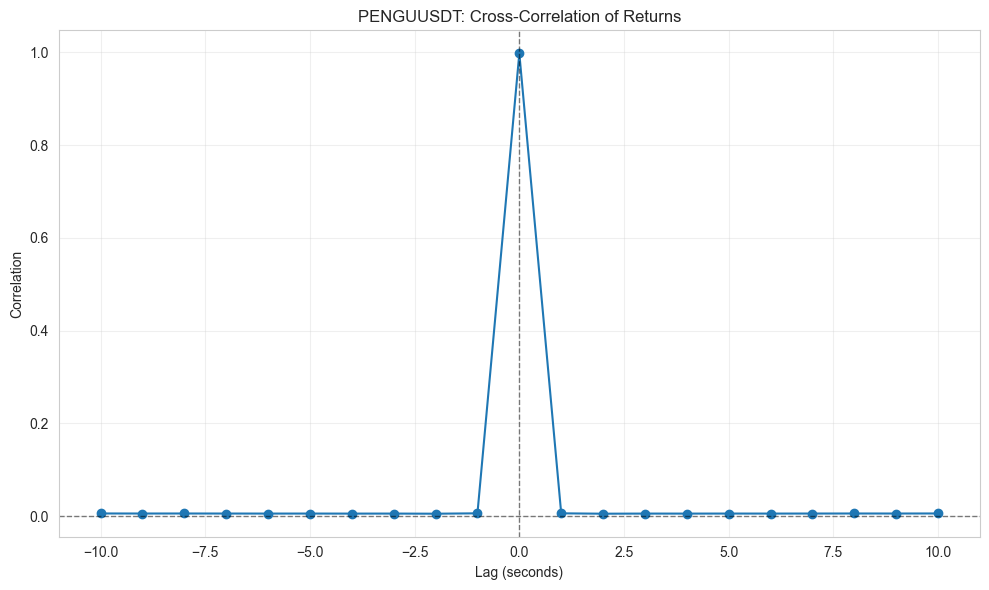


SOLUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.055210
1    -9     0.055179
2    -8     0.055063
3    -7     0.055055
4    -6     0.055077
5    -5     0.055272
6    -4     0.055154
7    -3     0.055358
8    -2     0.055380
9    -1     0.055260
10    0     0.998269
11    1     0.055260
12    2     0.055380
13    3     0.055358
14    4     0.055154
15    5     0.055272
16    6     0.055077
17    7     0.055055
18    8     0.055063
19    9     0.055179
20   10     0.055210

Best correlation: 0.9983 at lag 0
  → No significant lead-lag relationship


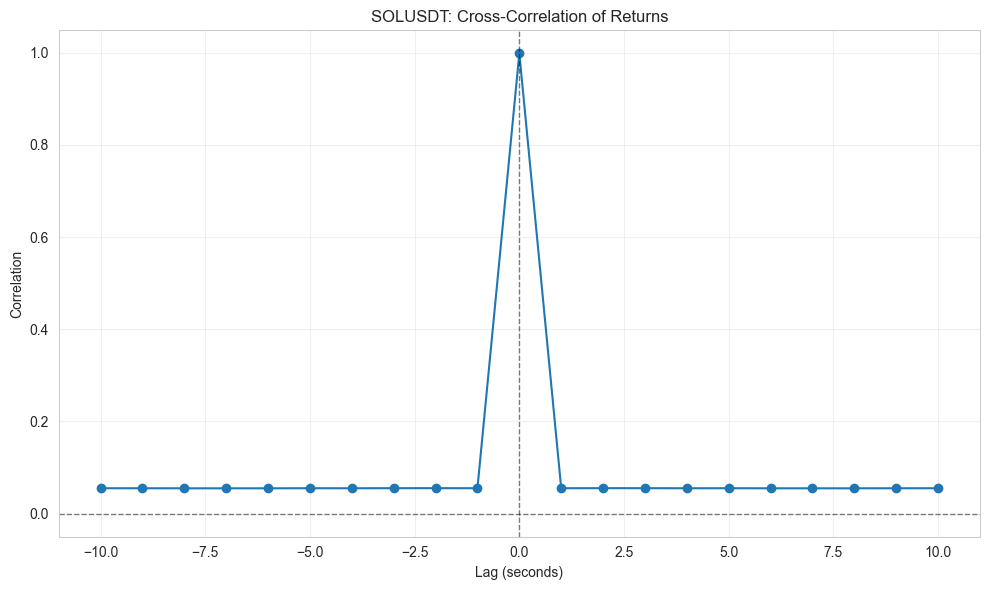


ONDOUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.060570
1    -9     0.060786
2    -8     0.060698
3    -7     0.060340
4    -6     0.060220
5    -5     0.060382
6    -4     0.060268
7    -3     0.060631
8    -2     0.059736
9    -1     0.061187
10    0     0.975101
11    1     0.061187
12    2     0.059736
13    3     0.060631
14    4     0.060268
15    5     0.060382
16    6     0.060220
17    7     0.060340
18    8     0.060698
19    9     0.060786
20   10     0.060570

Best correlation: 0.9751 at lag 0
  → No significant lead-lag relationship


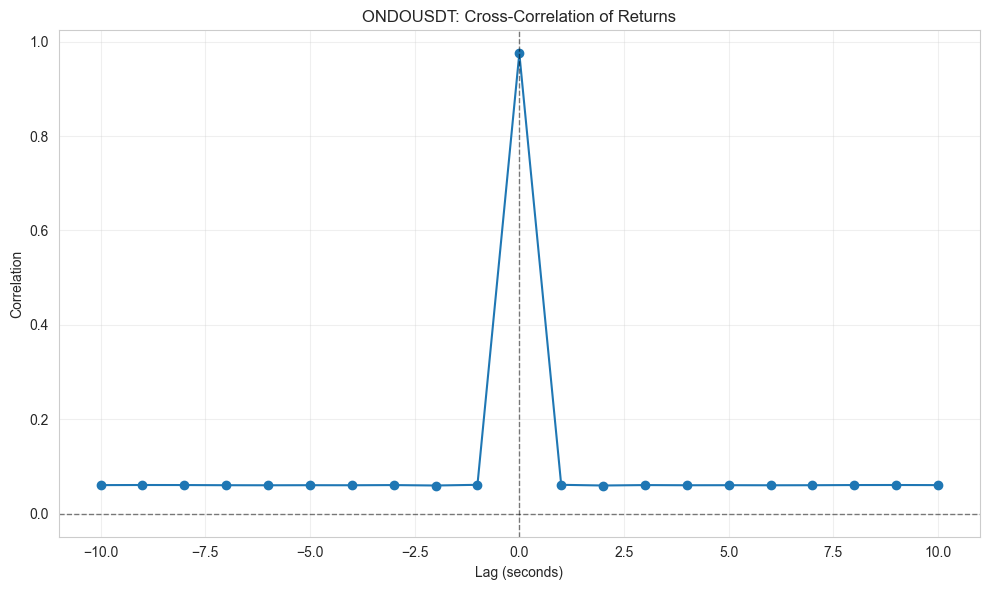


XRPUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.175543
1    -9     0.261816
2    -8     0.336966
3    -7     0.403956
4    -6     0.464690
5    -5     0.520646
6    -4     0.572561
7    -3     0.621098
8    -2     0.666933
9    -1     0.710323
10    0     0.998253
11    1     0.710323
12    2     0.666933
13    3     0.621098
14    4     0.572561
15    5     0.520646
16    6     0.464690
17    7     0.403956
18    8     0.336966
19    9     0.261816
20   10     0.175543

Best correlation: 0.9983 at lag 0
  → No significant lead-lag relationship


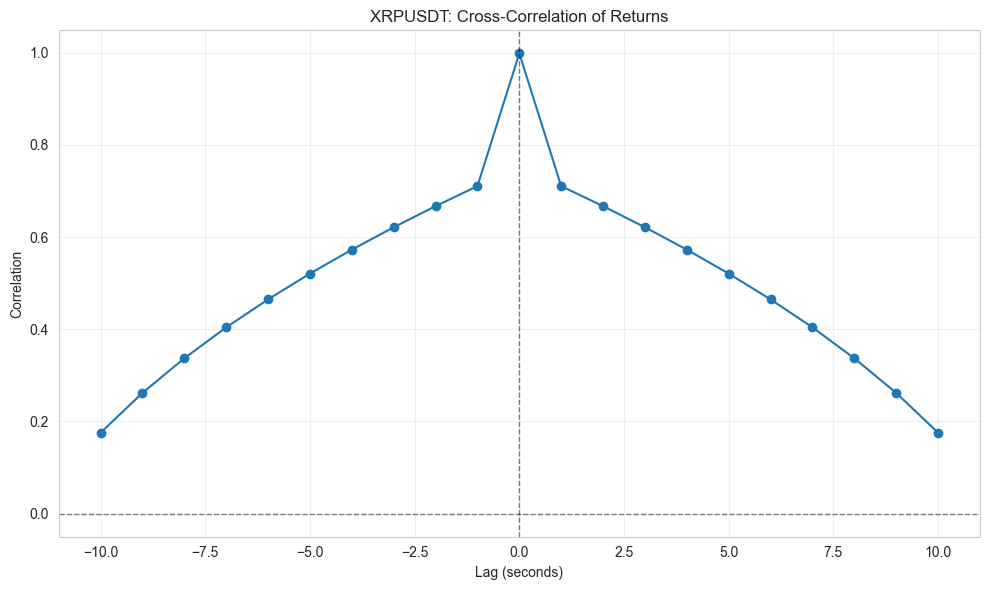


KAITOUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.295351
1    -9     0.295596
2    -8     0.295728
3    -7     0.295854
4    -6     0.295877
5    -5     0.296161
6    -4     0.295684
7    -3     0.295590
8    -2     0.328544
9    -1     0.359602
10    0     0.976934
11    1     0.359602
12    2     0.328544
13    3     0.295590
14    4     0.295684
15    5     0.296161
16    6     0.295877
17    7     0.295854
18    8     0.295728
19    9     0.295596
20   10     0.295351

Best correlation: 0.9769 at lag 0
  → No significant lead-lag relationship


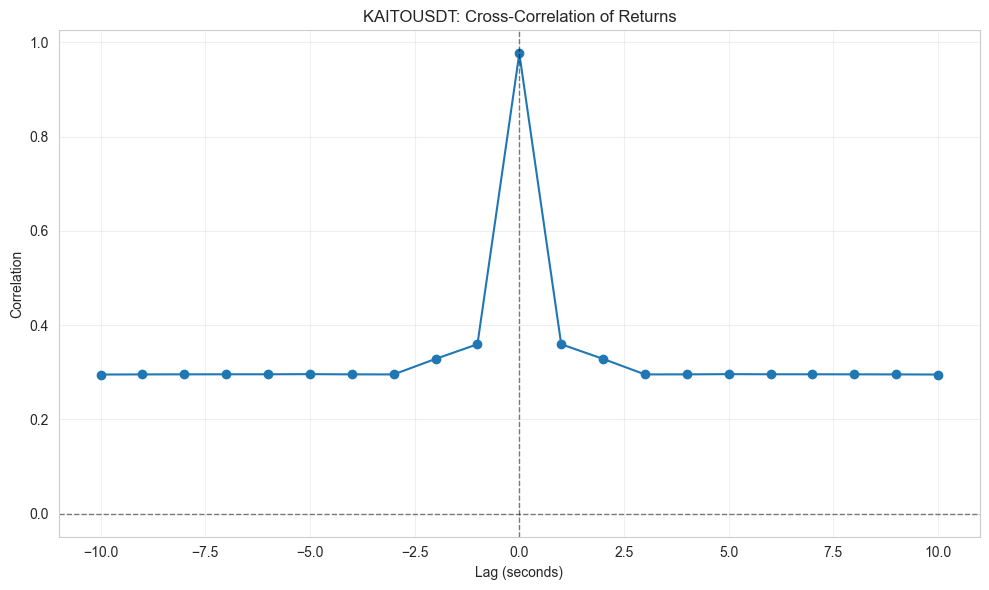


1000BONKUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.008364
1    -9     0.008407
2    -8     0.008401
3    -7     0.008401
4    -6     0.008487
5    -5     0.008445
6    -4     0.008346
7    -3     0.008345
8    -2     0.008350
9    -1     0.008320
10    0     0.999859
11    1     0.008320
12    2     0.008350
13    3     0.008345
14    4     0.008346
15    5     0.008445
16    6     0.008487
17    7     0.008401
18    8     0.008401
19    9     0.008407
20   10     0.008364

Best correlation: 0.9999 at lag 0
  → No significant lead-lag relationship


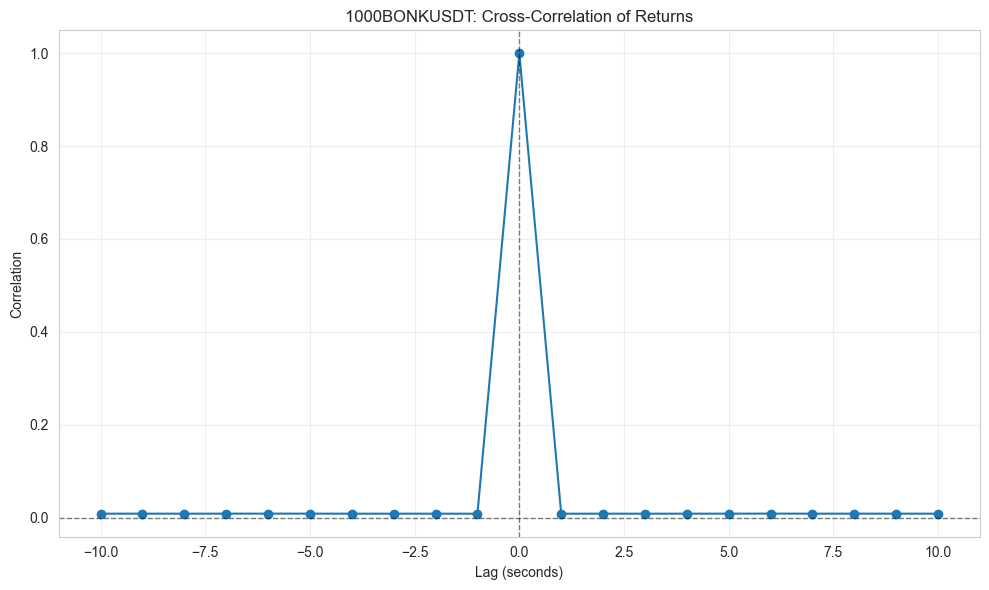


1000FLOKIUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.000741
1    -9     0.000721
2    -8     0.000726
3    -7     0.000742
4    -6     0.000745
5    -5     0.000736
6    -4     0.000736
7    -3     0.000730
8    -2     0.000716
9    -1     0.000823
10    0     0.999935
11    1     0.000823
12    2     0.000716
13    3     0.000730
14    4     0.000736
15    5     0.000736
16    6     0.000745
17    7     0.000742
18    8     0.000726
19    9     0.000721
20   10     0.000741

Best correlation: 0.9999 at lag 0
  → No significant lead-lag relationship


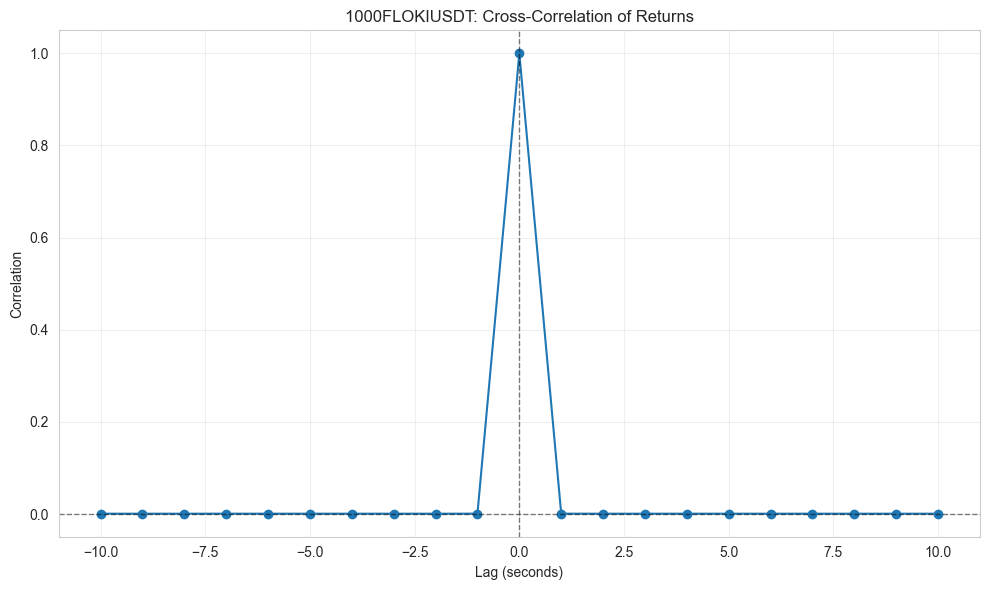


ADAUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.021698
1    -9     0.023193
2    -8     0.024634
3    -7     0.026150
4    -6     0.027654
5    -5     0.029128
6    -4     0.030586
7    -3     0.032095
8    -2     0.033595
9    -1     0.035043
10    0     0.999901
11    1     0.035043
12    2     0.033595
13    3     0.032095
14    4     0.030586
15    5     0.029128
16    6     0.027654
17    7     0.026150
18    8     0.024634
19    9     0.023193
20   10     0.021698

Best correlation: 0.9999 at lag 0
  → No significant lead-lag relationship


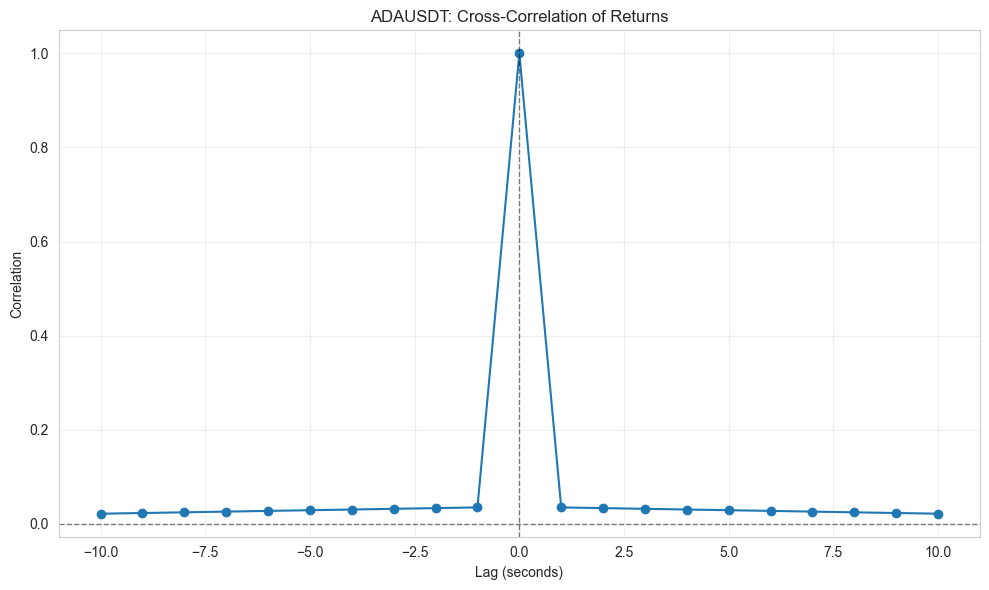


ARBUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.000539
1    -9     0.000520
2    -8     0.000474
3    -7     0.000421
4    -6     0.000392
5    -5     0.000417
6    -4     0.000382
7    -3     0.000432
8    -2     0.000431
9    -1     0.000399
10    0     0.999922
11    1     0.000399
12    2     0.000431
13    3     0.000432
14    4     0.000382
15    5     0.000417
16    6     0.000392
17    7     0.000421
18    8     0.000474
19    9     0.000520
20   10     0.000539

Best correlation: 0.9999 at lag 0
  → No significant lead-lag relationship


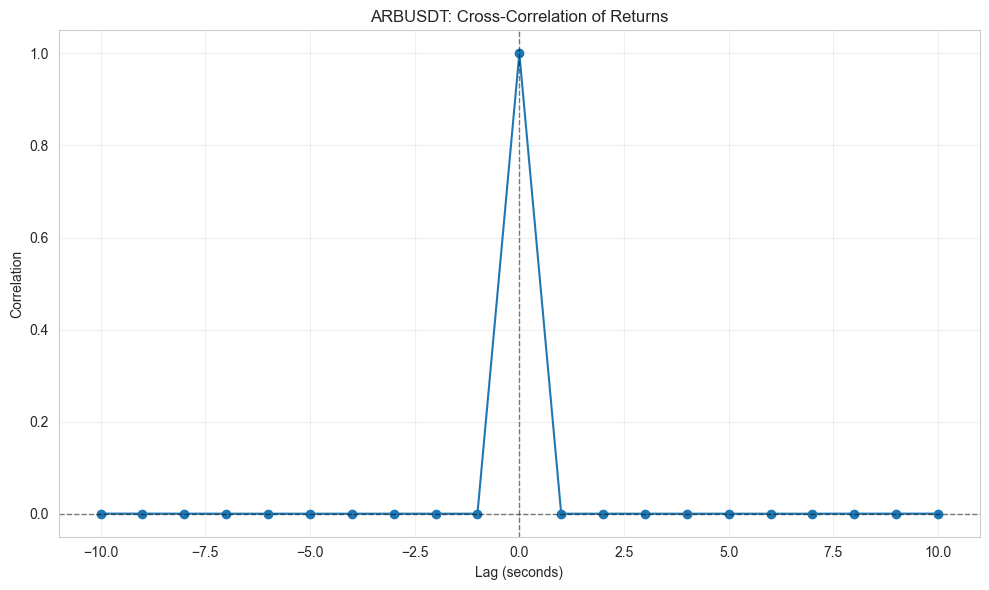


AVAXUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.676531
1    -9     0.689836
2    -8     0.703198
3    -7     0.716230
4    -6     0.729015
5    -5     0.741607
6    -4     0.754075
7    -3     0.766268
8    -2     0.778322
9    -1     0.790251
10    0     0.998415
11    1     0.790251
12    2     0.778322
13    3     0.766268
14    4     0.754075
15    5     0.741607
16    6     0.729015
17    7     0.716230
18    8     0.703198
19    9     0.689836
20   10     0.676531

Best correlation: 0.9984 at lag 0
  → No significant lead-lag relationship


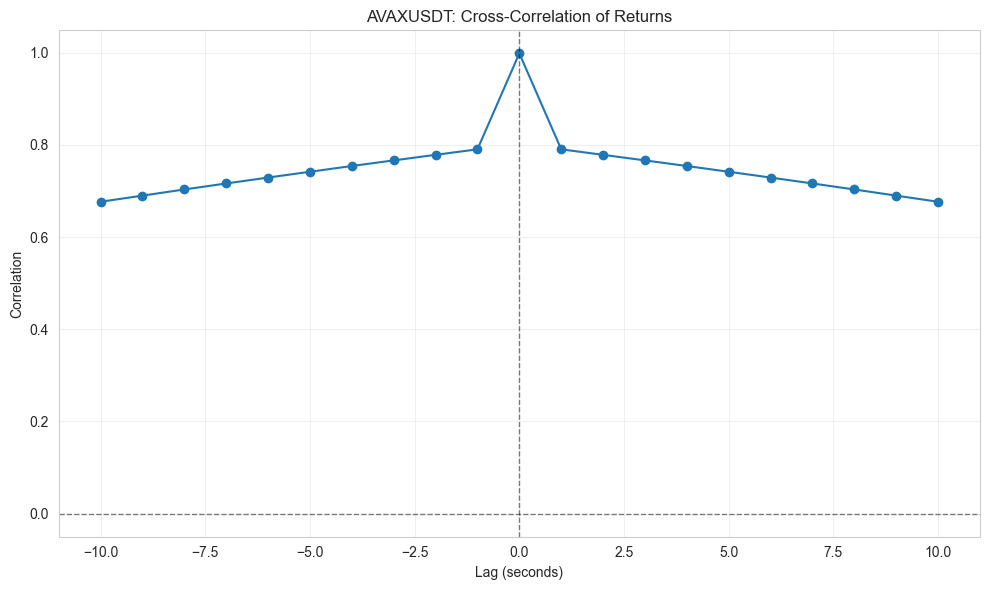


DOGEUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.002657
1    -9     0.002614
2    -8     0.002727
3    -7     0.002682
4    -6     0.002691
5    -5     0.002623
6    -4     0.002692
7    -3     0.002690
8    -2     0.002694
9    -1     0.002700
10    0     0.999427
11    1     0.002700
12    2     0.002694
13    3     0.002690
14    4     0.002692
15    5     0.002623
16    6     0.002691
17    7     0.002682
18    8     0.002727
19    9     0.002614
20   10     0.002657

Best correlation: 0.9994 at lag 0
  → No significant lead-lag relationship


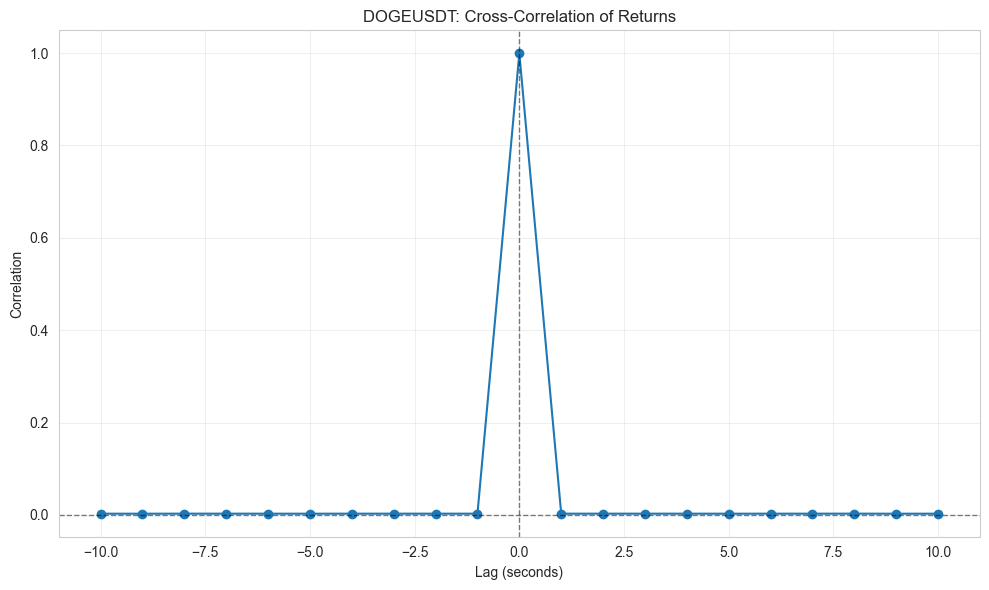


ENAUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.039051
1    -9     0.038389
2    -8     0.039480
3    -7     0.039100
4    -6     0.039187
5    -5     0.039538
6    -4     0.039421
7    -3     0.039568
8    -2     0.039509
9    -1     0.038811
10    0     0.991595
11    1     0.038811
12    2     0.039509
13    3     0.039568
14    4     0.039421
15    5     0.039538
16    6     0.039187
17    7     0.039100
18    8     0.039480
19    9     0.038389
20   10     0.039051

Best correlation: 0.9916 at lag 0
  → No significant lead-lag relationship


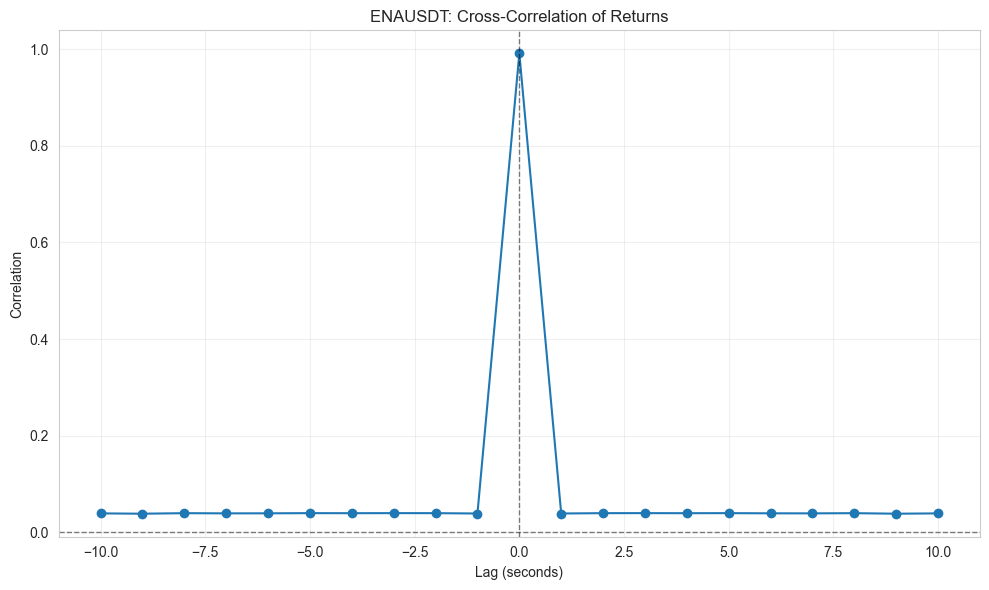


ETHFIUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.054757
1    -9     0.054268
2    -8     0.054608
3    -7     0.054594
4    -6     0.054614
5    -5     0.054628
6    -4     0.054606
7    -3     0.054563
8    -2     0.054635
9    -1     0.054722
10    0     0.996140
11    1     0.054722
12    2     0.054635
13    3     0.054563
14    4     0.054606
15    5     0.054628
16    6     0.054614
17    7     0.054594
18    8     0.054608
19    9     0.054268
20   10     0.054757

Best correlation: 0.9961 at lag 0
  → No significant lead-lag relationship


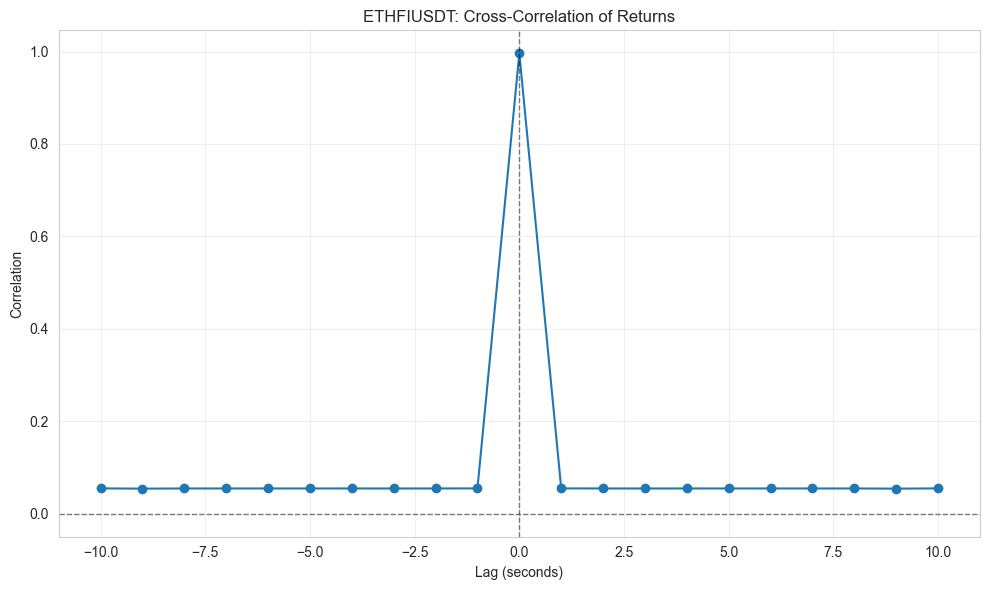


FETUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.113593
1    -9     0.113213
2    -8     0.113671
3    -7     0.114094
4    -6     0.114199
5    -5     0.114206
6    -4     0.113799
7    -3     0.113755
8    -2     0.113762
9    -1     0.113919
10    0     0.994878
11    1     0.113919
12    2     0.113762
13    3     0.113755
14    4     0.113799
15    5     0.114206
16    6     0.114199
17    7     0.114094
18    8     0.113671
19    9     0.113213
20   10     0.113593

Best correlation: 0.9949 at lag 0
  → No significant lead-lag relationship


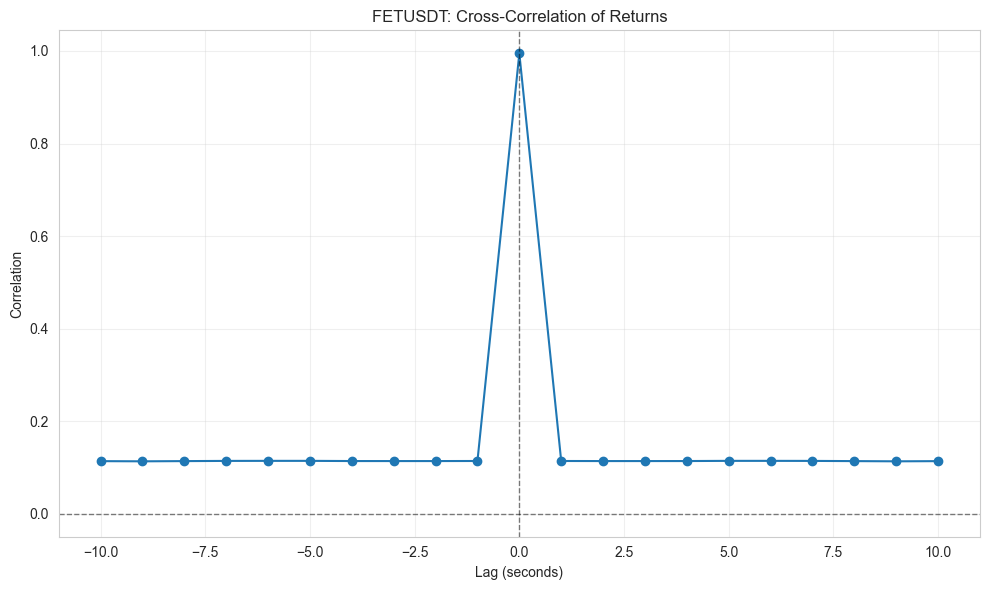


PNUTUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.006422
1    -9     0.006247
2    -8     0.006225
3    -7     0.006277
4    -6     0.006368
5    -5     0.006386
6    -4     0.006363
7    -3     0.006230
8    -2     0.006230
9    -1     0.006352
10    0     0.999330
11    1     0.006352
12    2     0.006230
13    3     0.006230
14    4     0.006363
15    5     0.006386
16    6     0.006368
17    7     0.006277
18    8     0.006225
19    9     0.006247
20   10     0.006422

Best correlation: 0.9993 at lag 0
  → No significant lead-lag relationship


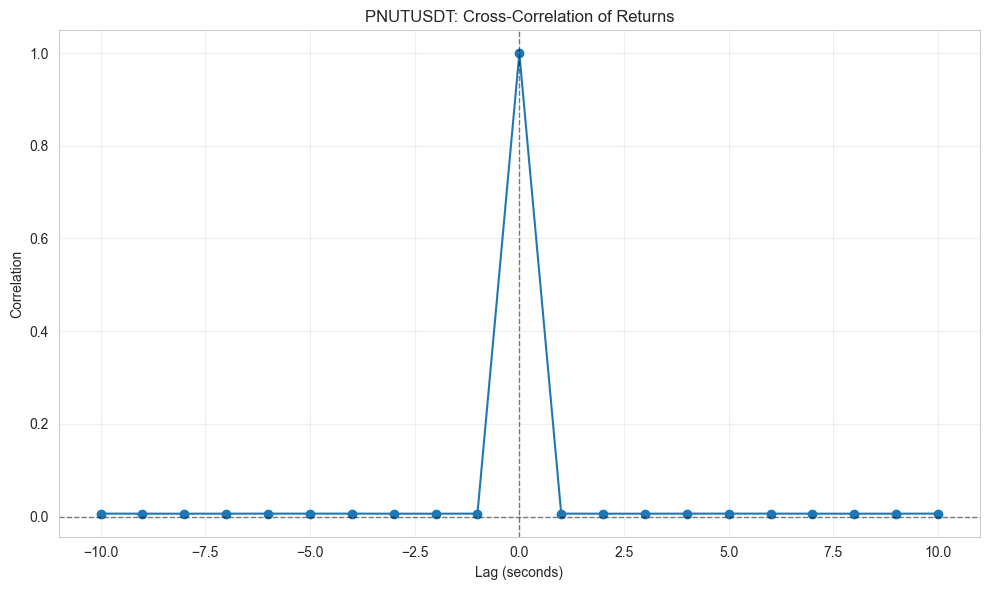


SKLUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.008156
1    -9     0.008152
2    -8     0.008189
3    -7     0.008175
4    -6     0.008124
5    -5     0.008120
6    -4     0.008196
7    -3     0.008180
8    -2     0.008205
9    -1     0.008148
10    0     0.999815
11    1     0.008148
12    2     0.008205
13    3     0.008180
14    4     0.008196
15    5     0.008120
16    6     0.008124
17    7     0.008175
18    8     0.008189
19    9     0.008152
20   10     0.008156

Best correlation: 0.9998 at lag 0
  → No significant lead-lag relationship


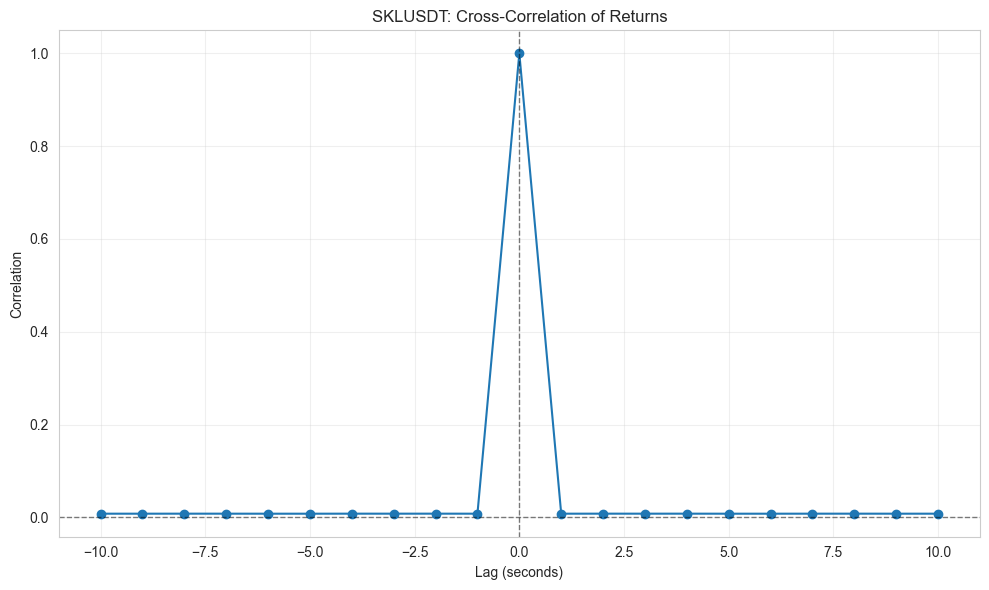


XCNUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.254593
1    -9     0.294150
2    -8     0.331725
3    -7     0.367549
4    -6     0.401406
5    -5     0.434268
6    -4     0.466026
7    -3     0.496539
8    -2     0.526255
9    -1     0.554366
10    0     0.993297
11    1     0.554366
12    2     0.526255
13    3     0.496539
14    4     0.466026
15    5     0.434268
16    6     0.401406
17    7     0.367549
18    8     0.331725
19    9     0.294150
20   10     0.254593

Best correlation: 0.9933 at lag 0
  → No significant lead-lag relationship


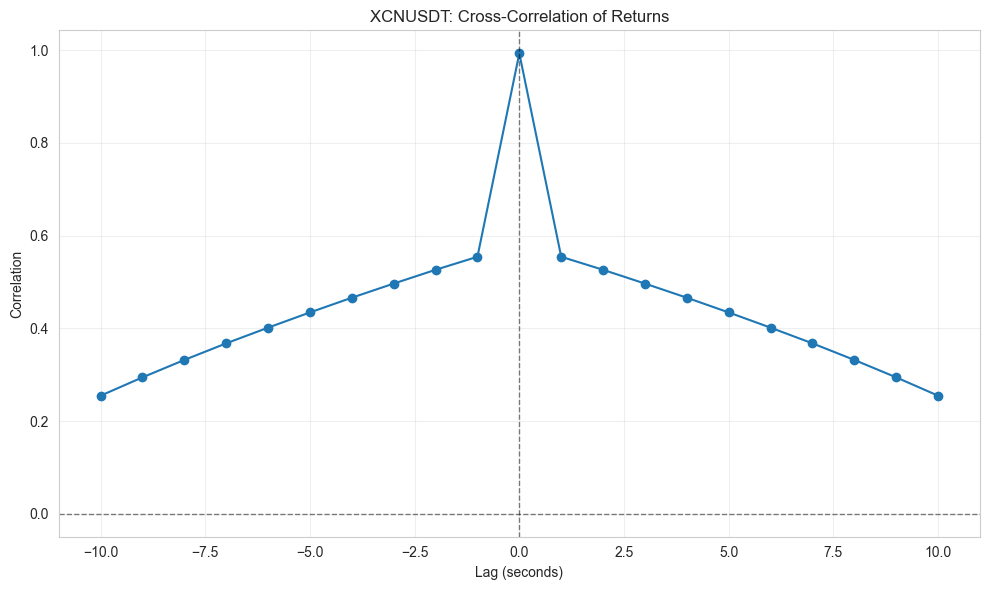


TRUMPUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.026309
1    -9     0.026281
2    -8     0.026365
3    -7     0.026643
4    -6     0.026277
5    -5     0.026239
6    -4     0.026253
7    -3     0.026220
8    -2     0.026310
9    -1     0.026382
10    0     0.997957
11    1     0.026382
12    2     0.026310
13    3     0.026220
14    4     0.026253
15    5     0.026239
16    6     0.026277
17    7     0.026643
18    8     0.026365
19    9     0.026281
20   10     0.026309

Best correlation: 0.9980 at lag 0
  → No significant lead-lag relationship


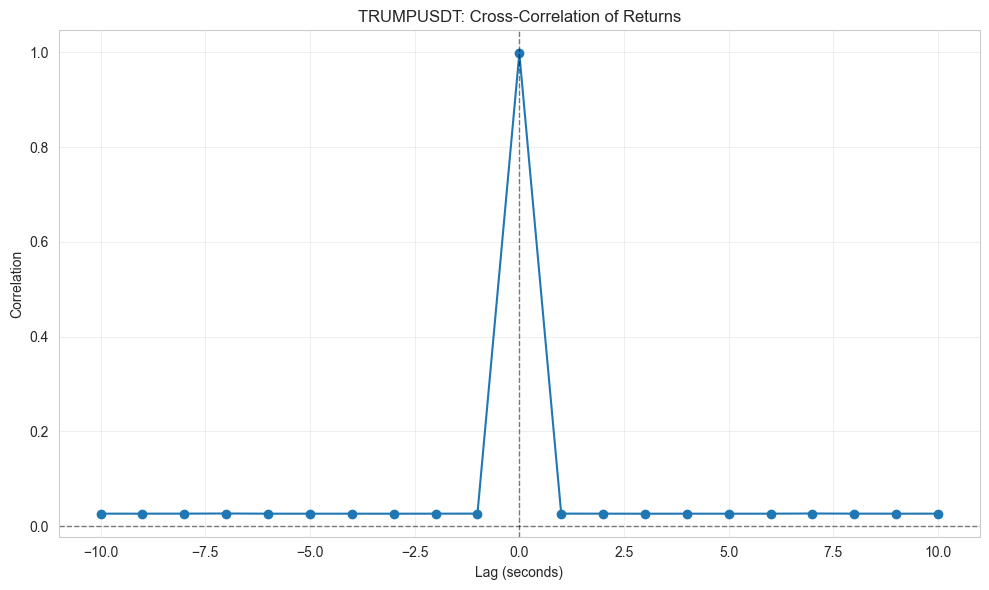


WLDUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.026238
1    -9     0.026165
2    -8     0.026038
3    -7     0.026176
4    -6     0.026173
5    -5     0.026215
6    -4     0.026532
7    -3     0.026342
8    -2     0.026408
9    -1     0.026325
10    0     0.998327
11    1     0.026325
12    2     0.026408
13    3     0.026342
14    4     0.026532
15    5     0.026215
16    6     0.026173
17    7     0.026176
18    8     0.026038
19    9     0.026165
20   10     0.026238

Best correlation: 0.9983 at lag 0
  → No significant lead-lag relationship


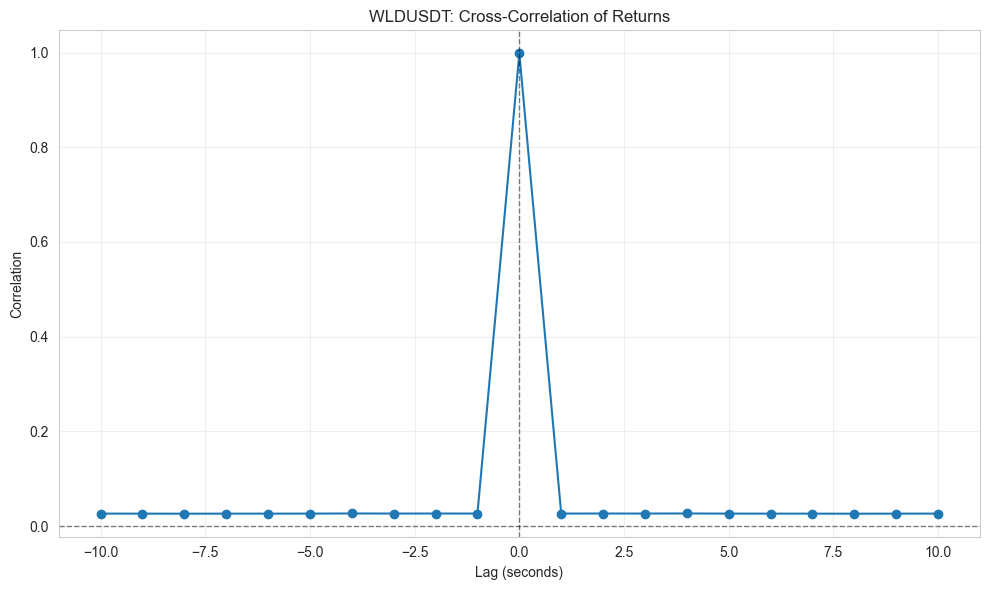


1000PEPEUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.016809
1    -9     0.016791
2    -8     0.016721
3    -7     0.016647
4    -6     0.016668
5    -5     0.016686
6    -4     0.016727
7    -3     0.016633
8    -2     0.016578
9    -1     0.016732
10    0     0.999451
11    1     0.016732
12    2     0.016578
13    3     0.016633
14    4     0.016727
15    5     0.016686
16    6     0.016668
17    7     0.016647
18    8     0.016721
19    9     0.016791
20   10     0.016809

Best correlation: 0.9995 at lag 0
  → No significant lead-lag relationship


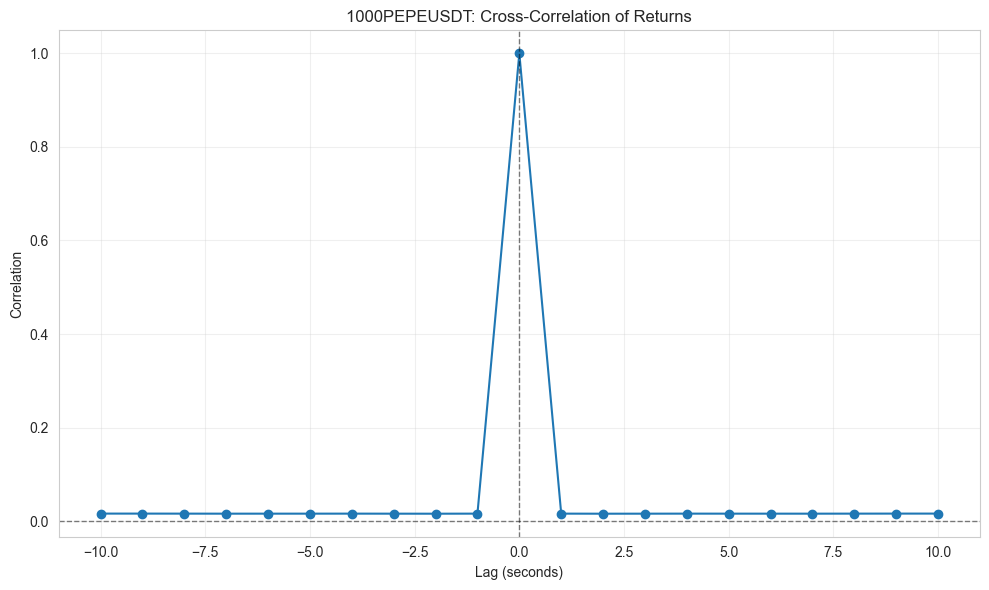


ASRUSDT - Lead-Lag Analysis:
    lag  correlation
0   -10     0.007368
1    -9     0.007359
2    -8     0.007242
3    -7     0.007255
4    -6     0.007252
5    -5     0.007241
6    -4     0.007240
7    -3     0.007182
8    -2     0.007182
9    -1     0.007158
10    0     0.999648
11    1     0.007158
12    2     0.007182
13    3     0.007182
14    4     0.007240
15    5     0.007241
16    6     0.007252
17    7     0.007255
18    8     0.007242
19    9     0.007359
20   10     0.007368

Best correlation: 0.9996 at lag 0
  → No significant lead-lag relationship


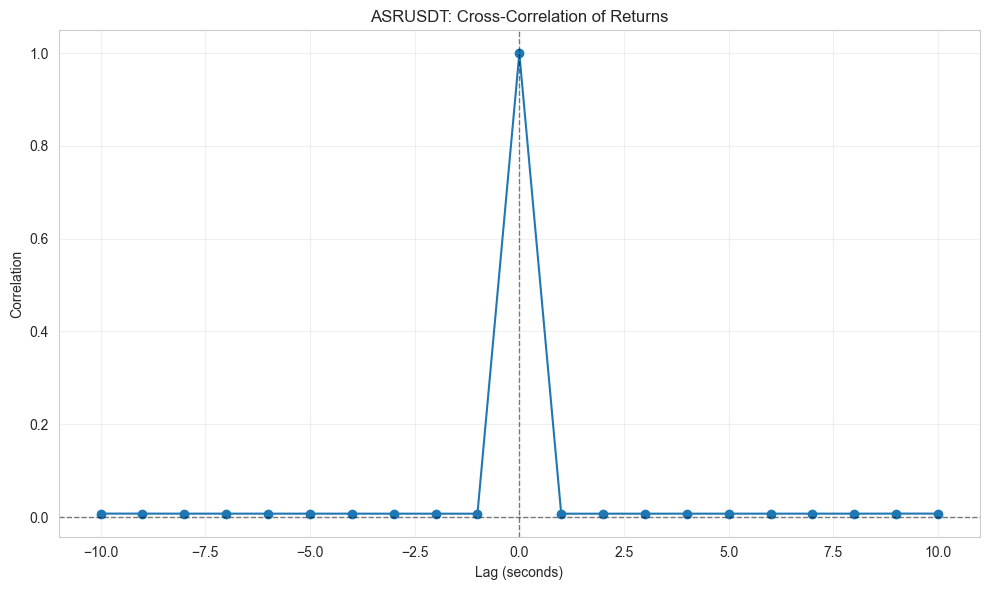

In [9]:
# Check lead-lag relationships
for symbol in df_aligned['symbol'].unique():
    symbol_data = df_aligned[df_aligned['symbol'] == symbol].dropna(subset=['ret_ex1', 'ret_ex2'])
    
    if len(symbol_data) > 0:
        cross_corr = calculate_cross_correlation(
            symbol_data['ret_ex1'], 
            symbol_data['ret_ex2'], 
            max_lag=10
        )
        
        print(f"\n{symbol} - Lead-Lag Analysis:")
        print(cross_corr)
        
        # Find best lag
        best_lag_idx = cross_corr['correlation'].abs().idxmax()
        best_lag = cross_corr.loc[best_lag_idx, 'lag']
        best_corr = cross_corr.loc[best_lag_idx, 'correlation']
        
        print(f"\nBest correlation: {best_corr:.4f} at lag {best_lag}")
        if best_lag > 0:
            print(f"  → Exchange 2 leads Exchange 1 by {best_lag} seconds")
        elif best_lag < 0:
            print(f"  → Exchange 1 leads Exchange 2 by {abs(best_lag)} seconds")
        else:
            print(f"  → No significant lead-lag relationship")
        
        # Plot cross-correlation
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(cross_corr['lag'], cross_corr['correlation'], marker='o')
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('Lag (seconds)')
        ax.set_ylabel('Correlation')
        ax.set_title(f'{symbol}: Cross-Correlation of Returns')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'../results/figures/cross_corr_{symbol}.png', dpi=150, bbox_inches='tight')
        plt.show()



## Step 5: Define Arbitrage Signal

Goal: Create a z-score based signal that identifies arbitrage opportunities above trading costs.

### Cost Assumptions:
- **ex1**: Trade fee 2 bps, execution at mid price
- **ex2**: Bid-ask spread 30 bps (15 bps each side), trade fee 8 bps
- **Total round-trip cost**: 50 bps (2 bps ex1 + 23 bps ex2 per leg, × 2 legs = 50 bps, excluding slippage)



In [10]:
# Calculate z-score signal
# Using 5-minute rolling window (300 seconds)
df_aligned = calculate_zscore_signal(
    df_aligned, 
    window=300,
    upper_threshold=3.0,
    lower_threshold=-3.0
)

# Filter signals by cost
df_aligned = filter_signal_by_cost(
    df_aligned,
    total_cost_bps=50.0,  # 50 bps round trip: (2 bps ex1 + 23 bps ex2) * 2 legs
    safety_buffer=1.2  # 20% safety buffer
)

print("✓ Signals calculated")
print(f"\nSignal distribution:")
print(df_aligned['signal_filtered'].value_counts())



✓ Signals calculated

Signal distribution:
signal_filtered
 0    2369867
 1      16360
-1       6595
Name: count, dtype: int64


## Step 6: Backtest Engine

Goal: Simulate trading strategy and track performance metrics.

### Strategy Parameters:
- **Hedge Style**: Fully delta-neutral (equal USD notional on both exchanges)
- **Notional per trade**: $100 USD
- **Entry**: When z-score crosses threshold and price difference exceeds costs
- **Exit**: When signal crosses back through zero



In [11]:
# Initialize backtest engine
backtest = BacktestEngine(
    notional=100.0,      # $100 per trade
    ex1_fee_bps=2.0,     # Exchange 1: 2 bps fee
    ex2_fee_bps=23.0     # Exchange 2: 15 bps spread + 8 bps fee = 23 bps per side
)

# Run backtest for each coin
all_trades = []
all_metrics = []

for symbol in df_aligned['symbol'].unique():
    print(f"\n{'='*80}")
    print(f"BACKTESTING: {symbol}")
    print(f"{'='*80}")
    
    trades_df = backtest.run_backtest(
        df_aligned, 
        symbol,
        signal_col='signal_filtered',
        timestamp_col='timestamp',
        symbol_col='symbol'
    )
    
    if len(trades_df) > 0:
        metrics = backtest.calculate_metrics(trades_df)
        all_trades.append(trades_df)
        all_metrics.append({**metrics, 'symbol': symbol})
        
        print(f"\nPerformance Metrics:")
        print(f"  Total trades: {metrics['total_trades']}")
        print(f"  Total PnL: ${metrics['total_pnl']:.2f}")
        print(f"  Win rate: {metrics['win_rate']*100:.2f}%")
        print(f"  Avg PnL per trade: ${metrics['avg_pnl']:.2f}")
        print(f"  Max drawdown: ${metrics['max_drawdown']:.2f}")
        print(f"  Avg holding time: {metrics['avg_holding_time_seconds']:.1f} seconds")
    else:
        print(f"No trades executed for {symbol}")

# Combine all trades
if all_trades:
    all_trades_df = pd.concat(all_trades, ignore_index=True)
    all_metrics_df = pd.DataFrame(all_metrics)
else:
    all_trades_df = pd.DataFrame()
    all_metrics_df = pd.DataFrame()




BACKTESTING: EIGENUSDT

Performance Metrics:
  Total trades: 958
  Total PnL: $-102.30
  Win rate: 32.99%
  Avg PnL per trade: $-0.11
  Max drawdown: $-128.16
  Avg holding time: 1.0 seconds

BACKTESTING: LPTUSDT

Performance Metrics:
  Total trades: 483
  Total PnL: $-10.72
  Win rate: 32.51%
  Avg PnL per trade: $-0.02
  Max drawdown: $-52.61
  Avg holding time: 2.1 seconds

BACKTESTING: NMRUSDT

Performance Metrics:
  Total trades: 304
  Total PnL: $-22.67
  Win rate: 30.26%
  Avg PnL per trade: $-0.07
  Max drawdown: $-52.11
  Avg holding time: 1.6 seconds

BACKTESTING: SNXUSDT

Performance Metrics:
  Total trades: 763
  Total PnL: $-137.47
  Win rate: 29.10%
  Avg PnL per trade: $-0.18
  Max drawdown: $-149.46
  Avg holding time: 0.6 seconds

BACKTESTING: PUMPUSDT

Performance Metrics:
  Total trades: 291
  Total PnL: $-62.08
  Win rate: 30.58%
  Avg PnL per trade: $-0.21
  Max drawdown: $-61.62
  Avg holding time: 0.6 seconds

BACKTESTING: TIAUSDT

Performance Metrics:
  Total t

In [12]:
# Display summary metrics
if len(all_metrics_df) > 0:
    print("\n" + "="*80)
    print("SUMMARY METRICS BY COIN")
    print("="*80)
    print(all_metrics_df.to_string(index=False))
    
    print("\n" + "="*80)
    print("OVERALL SUMMARY")
    print("="*80)
    print(f"Total trades: {all_trades_df['pnl'].count()}")
    print(f"Total PnL: ${all_trades_df['pnl'].sum():.2f}")
    print(f"Overall win rate: {(all_trades_df['pnl'] > 0).mean()*100:.2f}%")
    print(f"Average PnL per trade: ${all_trades_df['pnl'].mean():.2f}")




SUMMARY METRICS BY COIN
 total_trades   total_pnl  win_rate   avg_pnl  median_pnl  std_pnl  max_pnl   min_pnl  max_drawdown  avg_holding_time_seconds  median_holding_time_seconds        symbol
          958 -102.302531  0.329854 -0.106788   -0.500000 0.594899 3.354178 -0.871346   -128.162879                  0.953027                          0.0     EIGENUSDT
          483  -10.717978  0.325052 -0.022190   -0.220029 0.639860 3.043917 -0.506784    -52.613795                  2.130435                          1.0       LPTUSDT
          304  -22.666090  0.302632 -0.074560   -0.500000 0.690706 3.254187 -0.581989    -52.110245                  1.628289                          0.0       NMRUSDT
          763 -137.469043  0.290957 -0.180169   -0.500000 0.524950 4.704712 -0.573162   -149.463322                  0.593709                          0.0       SNXUSDT
          291  -62.075895  0.305842 -0.213319   -0.500000 0.442636 2.528140 -0.500000    -61.618985                  0.556701     

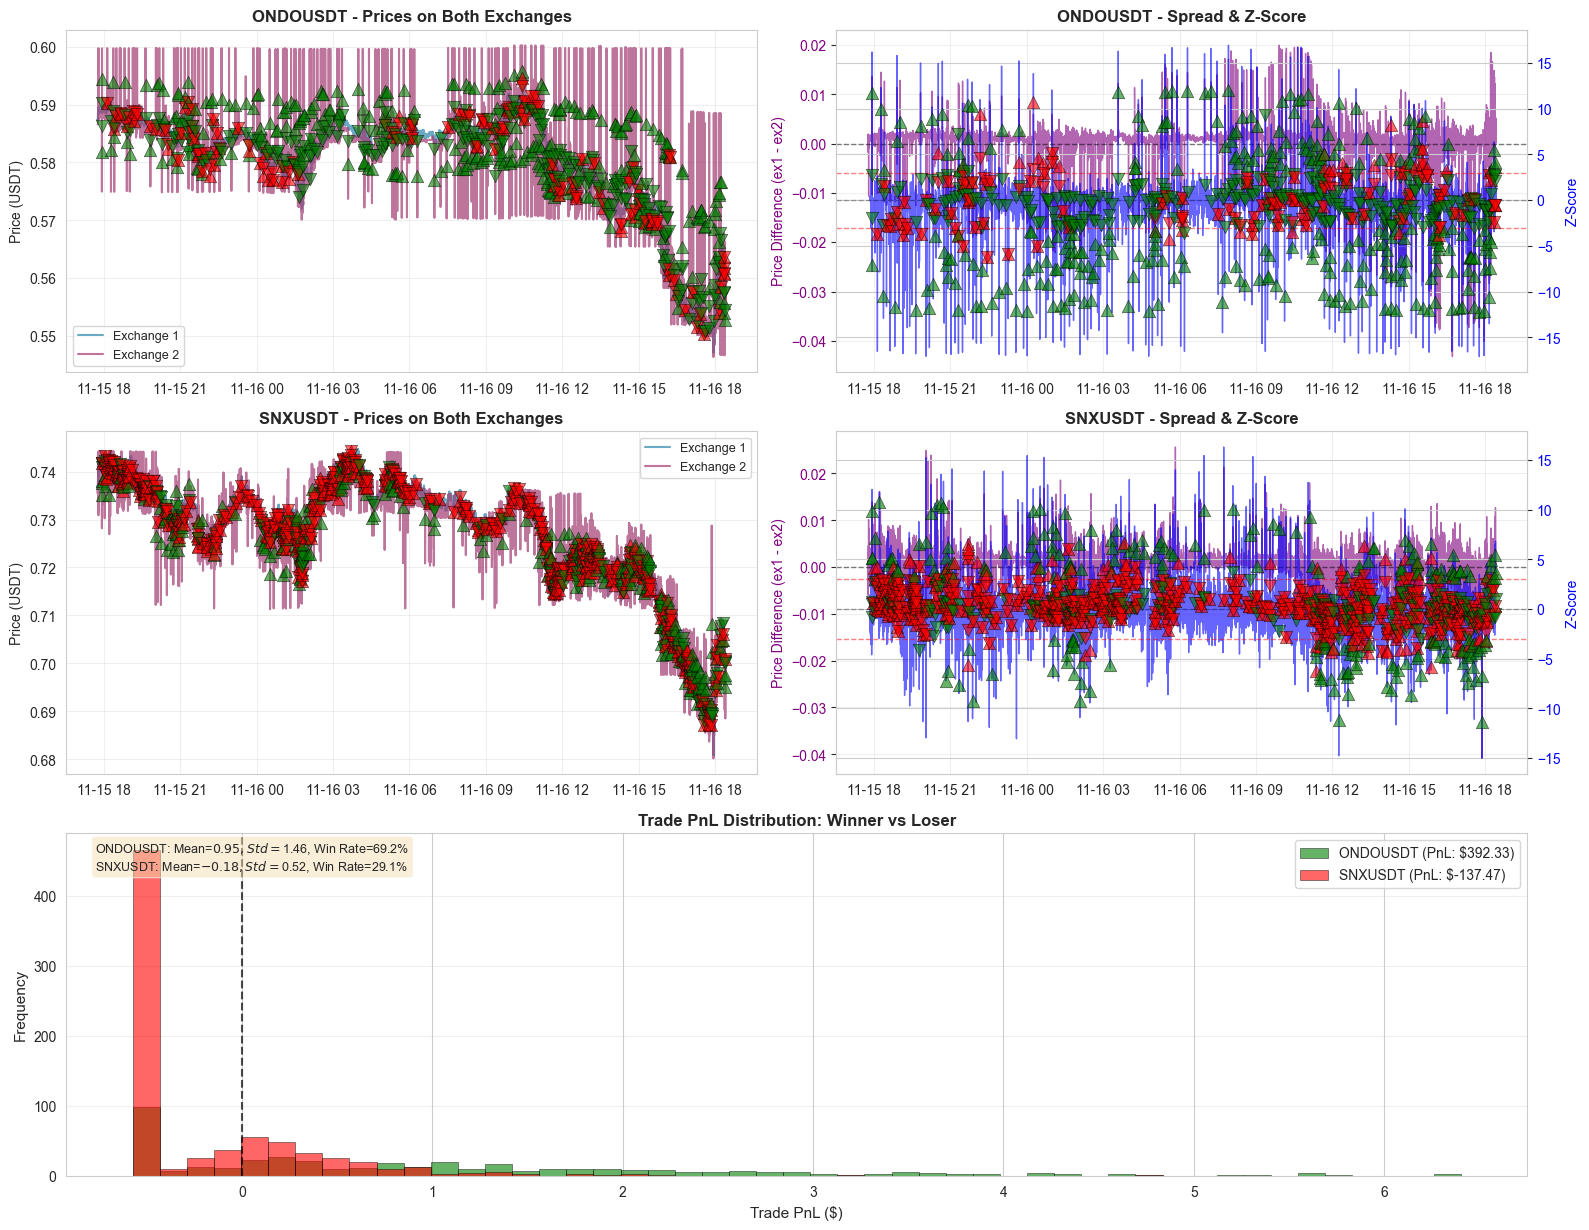


✓ Detailed visualization created:
  - ONDOUSDT: 415 trades, Total PnL: $392.33
  - SNXUSDT: 763 trades, Total PnL: $-137.47
  - Saved to: results/figures/winner_loser_analysis.png


In [13]:
# Detailed Visualizations: Winner vs Loser Analysis
# Compare ONDOUSDT (winner) vs SNXUSDT (loser) with price, spread, signals, and trade PnL

winner_symbol = 'ONDOUSDT'
loser_symbol = 'SNXUSDT'

# Get data for both symbols
winner_data = df_aligned[df_aligned['symbol'] == winner_symbol].copy().sort_values('timestamp')
loser_data = df_aligned[df_aligned['symbol'] == loser_symbol].copy().sort_values('timestamp')

# Get trades for both symbols
winner_trades = all_trades_df[all_trades_df['symbol'] == winner_symbol].copy().sort_values('entry_time')
loser_trades = all_trades_df[all_trades_df['symbol'] == loser_symbol].copy().sort_values('entry_time')

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 20))

# ========== WINNER (ONDOUSDT) ==========
# Row 1: Prices on both exchanges
ax1 = plt.subplot(5, 2, 1)
ax1.plot(winner_data['timestamp'], winner_data['mid_ex1'], 
         label='Exchange 1', alpha=0.7, linewidth=1.5, color='#2E86AB')
ax1.plot(winner_data['timestamp'], winner_data['mid_ex2'], 
         label='Exchange 2', alpha=0.7, linewidth=1.5, color='#A23B72')
ax1.set_ylabel('Price (USDT)', fontsize=10)
ax1.set_title(f'{winner_symbol} - Prices on Both Exchanges', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# Mark entry/exit points
for _, trade in winner_trades.iterrows():
    entry_time = trade['entry_time']
    exit_time = trade['exit_time']
    entry_price = (trade['entry_price_ex1'] + trade['entry_price_ex2']) / 2
    exit_price = (trade['exit_price_ex1'] + trade['exit_price_ex2']) / 2
    
    # Entry marker
    ax1.scatter(entry_time, entry_price, marker='^', s=80, 
               color='green' if trade['pnl'] > 0 else 'red', 
               alpha=0.6, edgecolors='black', linewidth=0.5, zorder=5)
    # Exit marker
    ax1.scatter(exit_time, exit_price, marker='v', s=80, 
               color='green' if trade['pnl'] > 0 else 'red', 
               alpha=0.6, edgecolors='black', linewidth=0.5, zorder=5)

# Row 2: Spread and Z-score
ax2 = plt.subplot(5, 2, 2)
ax2_twin = ax2.twinx()

# Price difference (spread)
ax2.plot(winner_data['timestamp'], winner_data['price_diff'], 
         alpha=0.6, linewidth=1, color='purple', label='Price Diff')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('Price Difference (ex1 - ex2)', fontsize=10, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Z-score
ax2_twin.plot(winner_data['timestamp'], winner_data['z_score'], 
              alpha=0.6, linewidth=1, color='blue', label='Z-Score')
ax2_twin.axhline(y=3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Upper threshold')
ax2_twin.axhline(y=-3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Lower threshold')
ax2_twin.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax2_twin.set_ylabel('Z-Score', fontsize=10, color='blue')
ax2_twin.tick_params(axis='y', labelcolor='blue')

ax2.set_title(f'{winner_symbol} - Spread & Z-Score', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Mark entry/exit on z-score
for _, trade in winner_trades.iterrows():
    entry_time = trade['entry_time']
    exit_time = trade['exit_time']
    entry_z = winner_data[winner_data['timestamp'] == entry_time]['z_score'].values
    exit_z = winner_data[winner_data['timestamp'] == exit_time]['z_score'].values
    
    if len(entry_z) > 0:
        ax2_twin.scatter(entry_time, entry_z[0], marker='^', s=80, 
                        color='green' if trade['pnl'] > 0 else 'red', 
                        alpha=0.6, edgecolors='black', linewidth=0.5, zorder=5)
    if len(exit_z) > 0:
        ax2_twin.scatter(exit_time, exit_z[0], marker='v', s=80, 
                        color='green' if trade['pnl'] > 0 else 'red', 
                        alpha=0.6, edgecolors='black', linewidth=0.5, zorder=5)

# ========== LOSER (SNXUSDT) ==========
# Row 3: Prices on both exchanges
ax3 = plt.subplot(5, 2, 3)
ax3.plot(loser_data['timestamp'], loser_data['mid_ex1'], 
         label='Exchange 1', alpha=0.7, linewidth=1.5, color='#2E86AB')
ax3.plot(loser_data['timestamp'], loser_data['mid_ex2'], 
         label='Exchange 2', alpha=0.7, linewidth=1.5, color='#A23B72')
ax3.set_ylabel('Price (USDT)', fontsize=10)
ax3.set_title(f'{loser_symbol} - Prices on Both Exchanges', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# Mark entry/exit points
for _, trade in loser_trades.iterrows():
    entry_time = trade['entry_time']
    exit_time = trade['exit_time']
    entry_price = (trade['entry_price_ex1'] + trade['entry_price_ex2']) / 2
    exit_price = (trade['exit_price_ex1'] + trade['exit_price_ex2']) / 2
    
    # Entry marker
    ax3.scatter(entry_time, entry_price, marker='^', s=80, 
               color='green' if trade['pnl'] > 0 else 'red', 
               alpha=0.6, edgecolors='black', linewidth=0.5, zorder=5)
    # Exit marker
    ax3.scatter(exit_time, exit_price, marker='v', s=80, 
               color='green' if trade['pnl'] > 0 else 'red', 
               alpha=0.6, edgecolors='black', linewidth=0.5, zorder=5)

# Row 4: Spread and Z-score
ax4 = plt.subplot(5, 2, 4)
ax4_twin = ax4.twinx()

# Price difference (spread)
ax4.plot(loser_data['timestamp'], loser_data['price_diff'], 
         alpha=0.6, linewidth=1, color='purple', label='Price Diff')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_ylabel('Price Difference (ex1 - ex2)', fontsize=10, color='purple')
ax4.tick_params(axis='y', labelcolor='purple')

# Z-score
ax4_twin.plot(loser_data['timestamp'], loser_data['z_score'], 
              alpha=0.6, linewidth=1, color='blue', label='Z-Score')
ax4_twin.axhline(y=3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Upper threshold')
ax4_twin.axhline(y=-3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Lower threshold')
ax4_twin.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax4_twin.set_ylabel('Z-Score', fontsize=10, color='blue')
ax4_twin.tick_params(axis='y', labelcolor='blue')

ax4.set_title(f'{loser_symbol} - Spread & Z-Score', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Mark entry/exit on z-score
for _, trade in loser_trades.iterrows():
    entry_time = trade['entry_time']
    exit_time = trade['exit_time']
    entry_z = loser_data[loser_data['timestamp'] == entry_time]['z_score'].values
    exit_z = loser_data[loser_data['timestamp'] == exit_time]['z_score'].values
    
    if len(entry_z) > 0:
        ax4_twin.scatter(entry_time, entry_z[0], marker='^', s=80, 
                        color='green' if trade['pnl'] > 0 else 'red', 
                        alpha=0.6, edgecolors='black', linewidth=0.5, zorder=5)
    if len(exit_z) > 0:
        ax4_twin.scatter(exit_time, exit_z[0], marker='v', s=80, 
                        color='green' if trade['pnl'] > 0 else 'red', 
                        alpha=0.6, edgecolors='black', linewidth=0.5, zorder=5)

# Row 5: Trade PnL Histogram Comparison
ax5 = plt.subplot(5, 2, (5, 6))

# Prepare data for histogram
winner_pnl = winner_trades['pnl'].values
loser_pnl = loser_trades['pnl'].values

# Create histogram
bins = np.linspace(min(min(winner_pnl), min(loser_pnl)), 
                   max(max(winner_pnl), max(loser_pnl)), 50)

ax5.hist(winner_pnl, bins=bins, alpha=0.6, label=f'{winner_symbol} (PnL: ${winner_trades["pnl"].sum():.2f})', 
         color='green', edgecolor='black', linewidth=0.5)
ax5.hist(loser_pnl, bins=bins, alpha=0.6, label=f'{loser_symbol} (PnL: ${loser_trades["pnl"].sum():.2f})', 
         color='red', edgecolor='black', linewidth=0.5)

ax5.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax5.set_xlabel('Trade PnL ($)', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Trade PnL Distribution: Winner vs Loser', fontsize=12, fontweight='bold')
ax5.legend(loc='best', fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# Add statistics text
stats_text = f'{winner_symbol}: Mean=${winner_pnl.mean():.2f}, Std=${winner_pnl.std():.2f}, Win Rate={len(winner_pnl[winner_pnl>0])/len(winner_pnl)*100:.1f}%\n'
stats_text += f'{loser_symbol}: Mean=${loser_pnl.mean():.2f}, Std=${loser_pnl.std():.2f}, Win Rate={len(loser_pnl[loser_pnl>0])/len(loser_pnl)*100:.1f}%'
ax5.text(0.02, 0.98, stats_text, transform=ax5.transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../results/figures/winner_loser_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Detailed visualization created:")
print(f"  - {winner_symbol}: {len(winner_trades)} trades, Total PnL: ${winner_trades['pnl'].sum():.2f}")
print(f"  - {loser_symbol}: {len(loser_trades)} trades, Total PnL: ${loser_trades['pnl'].sum():.2f}")
print(f"  - Saved to: results/figures/winner_loser_analysis.png")


## Step 8: Summary and Findings

### Key Findings Summary



In [14]:
# Save results to CSV
if len(all_trades_df) > 0:
    all_trades_df.to_csv('../results/reports/all_trades.csv', index=False)
    print("✓ Saved trades to results/reports/all_trades.csv")

if len(all_metrics_df) > 0:
    all_metrics_df.to_csv('../results/reports/performance_metrics.csv', index=False)
    print("✓ Saved metrics to results/reports/performance_metrics.csv")

# Save aligned data sample
df_aligned.head(1000).to_csv('../results/reports/aligned_data_sample.csv', index=False)
print("✓ Saved aligned data sample to results/reports/aligned_data_sample.csv")

print("\n✓ Analysis complete!")



✓ Saved trades to results/reports/all_trades.csv
✓ Saved metrics to results/reports/performance_metrics.csv
✓ Saved aligned data sample to results/reports/aligned_data_sample.csv

✓ Analysis complete!
